## Перед началом работы

#### Примапим диск

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Устанавливаем зависимости

In [ ]:
repo_folder = '/content/drive/MyDrive/github/'

In [ ]:
reqs_path = repo_folder + 'IntelligentDocumentProcessing/requirements.txt '
!pip3 install -r {reqs_path}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 31.4 MB/s 
     |████████████████████████████████| 604 kB 71.9 MB/s 
     |████████████████████████████████| 707 kB 64.0 MB/s 
     |████████████████████████████████| 97 kB 9.2 MB/s 
     |████████████████████████████████| 49.9 MB 1.8 MB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
     |████████████████████████████████| 5.3 MB 47.9 MB/s 
     |████████████████████████████████| 101 kB 14.1 MB/s 
     |████████████████████████████████| 175 kB 70.0 MB/s 
     |████████████████████████████████| 182 kB 60.9 MB/s 
     |████████████████████████████████| 168 kB 75.7 MB/s 
     |████████████████████████████████| 529 kB 66.3 MB/s 
     |████████████████████████████████| 2.1 MB 53.5 MB/s 
     |████████████████████████████████| 182 kB 71.9 MB/s 
     |████████████████████████████████| 7.6 MB 51.8 MB/s 
     |█████████████████████████████

#### Проверим корректность установки библиотек после перезагрузки ядра

In [ ]:
import sys

# Библиотеки для нейронных сетей
import torch                                                            # The one and the only
import pytorch_lightning as pl                                          # Циклы обучения и инструменты
from sklearn.metrics import f1_score, classification_report             # Метрики для задачи
from torch.utils.data import Dataset, DataLoader, random_split          # Утилиты для работы с данными PyTorch
from transformers import BertTokenizer, BertForTokenClassification      # Библиотека, где можно разжиться предобученными трансформерными моделями


## Сериализация и коллекции

import json
import collections
from typing import List, Tuple, Callable, Dict, Set, Union
from glob import glob


## NLP инструменты (разбиение текста на нормализованные слова)
from rusenttokenize import ru_sent_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import wordpunct_tokenize


## Отрисовка и представление
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image
from ipymarkup import show_span_line_markup

sns.set_theme(style="white", context="talk")
plt.style.use('default')
%matplotlib inline

#### Добавим путь запуска

In [ ]:
base_folder = repo_folder + 'IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/'
sys.path.append(base_folder)

# 0. Введение

## 0.1. Распознавание именованных сущностей


Мы нашли текст на документе, распознали символы, из которых текст состоит и связали символы в слова и предложения.

В нашем проекте нам необходимо над текстом сделать некоторую аналитику: распознать названия и имена в тексте (в нашей задаче будем распознавать только имена и названия организаций).

Такая задача носит название распознавания именованных сущностей (NER, Named Entity Recognition). Эту задачу мы будем решать при помощи нейросетей для анализа языка.

Стоит отметить, что многие задачи обработки естественного языка (NLP, Natural Language Processing), решаются подобным образом, поэтому опыт и знания, полученные в этом ноутбуке можно использвать и для других задач.


Какие сущности мы будем распознавать:

*   **PER, Персона**, например, Элвис Пресли, Одри Хепберн, Дэвид Бекхэм
*   **ORG, Организация**, например, Google, Mastercard, Оксфордский университет

Какие еще сущности входят в задачу NER
*   **Дата-Время** например, 2006, 16:34, 2 часа ночи
*   **Локация**, например, Трафальгарская площадь, МоМА, Мачу-Пикчу.
*   **Произведение искусства**, например, «Гамлет», «Мона Лиза».

## 0.2. План работы



1. Подготовка данных
    1. Загрузка данных и знакомство с форматом хранения
    2. Анализ статистики данных
    3. Упрощение данных
    4. Нормализация данных
    5. Создание скрипта датасета
2. Подготовка нейронной сети
3. Функция потерь
4. Метрики
5. Обучение модели
6. Анализ ошибок
7. Конверация в jit

# 1. Данные

## 1.1. Общая информация

В этом ноутбуке мы будет работать с данными из соревнования [RuNNE](https://github.com/dialogue-evaluation/RuNNE) -  "извлечение именованных сущностей в few-shot режиме".
Главная особенность этого набора данных - множественная вложенность сущностей (включая вложенность сущностей одного типа).

В этой тетрадке мы не будем говорить о few-shot подходах, по этой теме есть наша [статья на хабр](https://habr.com/ru/company/sberbank/blog/649609/). В ней можно познакомиться с инсайдами по данной теме и узнать, что явлется SOTA. Кроме того, работать с вложенностью мы пока тоже не будем. 

После проведения анализа мы упростим задачу и оставим только неперсекающие сущности: слона будем есть по частям :)

## 1.2. Загрузка данных

Данные, которые мы будем использовать в этом ноутбуке, хранятся в формате **BRAT**.

Наша задача -- считать данные из хранилища и преобразовать их таким образом, чтобы они были удобны для обучения нейронной сети.

Вообще **BRAT** -- это онлайн-инструмент для разметки письменных текстов. Детальное описание можно найти [здесь](https://brat.nlplab.org/introduction.html)

Также **BRAT** -- это и формат хранения данных, который был разработан для этого инструмента. Именно в этом формате лежат те данные, которые нас интересуют в этом ноутбуке.

Функция ```read_annotation``` позволяет считывать данные в этом формате. (Код доступен в папке ```utils```).

В этой функции происходит следующее:
* Для каждого текста в датасете:
    * Считывается текст из файла для текста
    * Из соседнего файла для разметки считывается разметка в формате ```(str: Label, long: Start, long: End)```

Результат складывается в ```list```, в котором хранится полный набор данных.


### 1.2.1. Загрузка данных

In [ ]:
data_path = repo_folder + "IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/"
!unzip -q {data_path + "RuNNE.zip"} -d {data_path}

replace /content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/__MACOSX/._RuNNE? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuNNE/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuNNE/baseline/baseline.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuNNE/baseline/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuNNE/baseline/baseline.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuNNE/baseline/iobes_flat_dataset.py? [y]es, [n]o,

In [ ]:
!head -n 10 {data_path + "RuNNE/data/train/003.ann"}

T1	NATIONALITY 62 74	американцами
T2	CITY 82 89	Бишкеке
T3	DATE 117 126	5 августа
T5	ORGANIZATION 145 179	Правоохранительные органы Киргизии
T6	COUNTRY 171 179	Киргизии
T7	COUNTRY 221 224	США
T8	CITY 227 234	Бишкеке
T9	DATE 288 298	во вторник
T10	ORGANIZATION 312 315	МВД
T12	CITY 433 440	Ынтымак


In [ ]:
!head -n 6 {data_path + "RuNNE/data/train/003.txt"}

Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке

05/08/2008 10:35

БИШКЕК, 5 августа /Новости-Грузия/. Правоохранительные органы Киргизии обнаружили в доме, арендуемом гражданами США в Бишкеке, пулеметы, автоматы и снайперские винтовки, сообщает во вторник пресс-служба МВД Киргизии.



In [ ]:
from utils import read_annotation

train_data = read_annotation(data_path + "RuNNE/data/train", "RuNNE-Train")
valid_data = read_annotation(data_path + "RuNNE/data/dev", "RuNNE-Dev")
test_data = read_annotation(data_path + "RuNNE/data/test", "RuNNE-Test")

Read RuNNE-Train data...:   0%|          | 0/461 [00:00<?, ?it/s]

Read RuNNE-Dev data...:   0%|          | 0/323 [00:00<?, ?it/s]

Read RuNNE-Test data...:   0%|          | 0/93 [00:00<?, ?it/s]

### 1.2.2. Проверка работы

In [ ]:
datum = train_data[0]
print("====== Первые 100 символов текста ======")
print(datum[0][:100])
print("")
print("====== Первые 10 сущностей ======")
print(datum[1][:10])
print("")

====== Первые 100 символов текста ======
Путин: Росгвардия будет охранять губернаторов

Владимир Путин и Виктор Золотов
Росгвардия наделяется

====== Первые 10 сущностей ======
[(0, 5, 'PERSON'), (7, 17, 'ORGANIZATION'), (33, 45, 'PROFESSION'), (47, 61, 'PERSON'), (64, 78, 'PERSON'), (79, 89, 'ORGANIZATION'), (175, 177, 'COUNTRY'), (215, 222, 'ORGANIZATION'), (223, 232, 'PROFESSION'), (233, 247, 'PERSON')]



Формат вывода не самый информативный. [ipymarkup](https://github.com/natasha/ipymarkup) - удобая библиотека, которая позволяет отобразить разметку более наглядно, используя HTML.

[Документация](http://nbviewer.jupyter.org/github/natasha/ipymarkup/blob/master/docs.ipynb)

In [ ]:
show_span_line_markup(*train_data[0])

Такой вариант выглядит гораздо более понятно

## 1.3. Разбиение на предложения и на слова. Токенизация

Мы загрузили тексты из датасета. С тем, что уже есть можно начинать работу: разобьем текст на предложения, а предложения на слова -- и дальше работаем со словами.

Но, как мы разбирали в лекции, задача значительно упростится, если текст предобработать: токенизировать.

Для токенизации существуют отдельные модели. В нашем случае мы будем использовать BERT токенизатор. Да, тот самый BERT, из которого мы будем делать нашу модель чуть позже.

Токенизацию можно делать при помощи множества различных инструментов. Это могут быть как эвристические решения, так и нейросетевые модели.

### 1.3.1. Сколько каждый документ содержит предложений?


#### Задача 0. 
Сегментация с сохранением координат. Необходимо воспользоваться библиотекой RuSentTokenize, а также добавить разбиение по новым строкам.
На вход: список новостей
На выход: список предложений с координатами

In [ ]:
from rusenttokenize import ru_sent_tokenize
import re

In [ ]:
# Заготовка

def sentence_segmentation(
    texts: List[str], return_coords: bool = False
) -> List[List[str]]:
    sent_per_text = []
    """
    Ваш код здесь
    """
    sent_per_text = []
    for text in texts:
      first_segm = [sent for sent in ru_sent_tokenize(text)]
      second_segm = [s for sent in first_segm for s in re.split('\n', sent) if s]
      
      for sent in second_segm:
        if not return_coords:
          sent_per_text.append(sent)
          continue
        start_pos = text.find(sent)
        sent_per_text.append((start_pos, start_pos + len(sent), sent))
    return sent_per_text

In [ ]:
# Проверка

check_text = "Д.Медведев снял с должности замсекретаря Совбеза РФ Ю.Балуевского\n\nПрезидент России Дмитрий Медведев освободил Юрия Балуевского от должности замсекретаря Совета безопасности России. Соответствующий указ опубликован на сайте государственной системы правовой информации.\n\nУказ глава государства подписал 9 января."

sents_with_coords = [
    (0, 65, 'Д.Медведев снял с должности замсекретаря Совбеза РФ Ю.Балуевского'),
    (67, 181, 'Президент России Дмитрий Медведев освободил Юрия Балуевского от должности замсекретаря Совета безопасности России.'),
    (182, 268,'Соответствующий указ опубликован на сайте государственной системы правовой информации.'),
    (270, 311, 'Указ глава государства подписал 9 января.')
]
sents_without_coords = [
    'Д.Медведев снял с должности замсекретаря Совбеза РФ Ю.Балуевского',
    'Президент России Дмитрий Медведев освободил Юрия Балуевского от должности замсекретаря Совета безопасности России.',
    'Соответствующий указ опубликован на сайте государственной системы правовой информации.',
    'Указ глава государства подписал 9 января.'
]

for expected_res, bool_value in [(sents_with_coords, True),(sents_without_coords,False)]:
    res = sentence_segmentation([check_text], bool_value)
    assert res == expected_res
    
print("Good job")

Good job


In [ ]:
train_sents_per_doc = sentence_segmentation([text for text, _ in train_data])
valid_sents_per_doc = sentence_segmentation([text for text, _ in valid_data])
test_sents_per_doc = sentence_segmentation([text for text, _ in test_data])

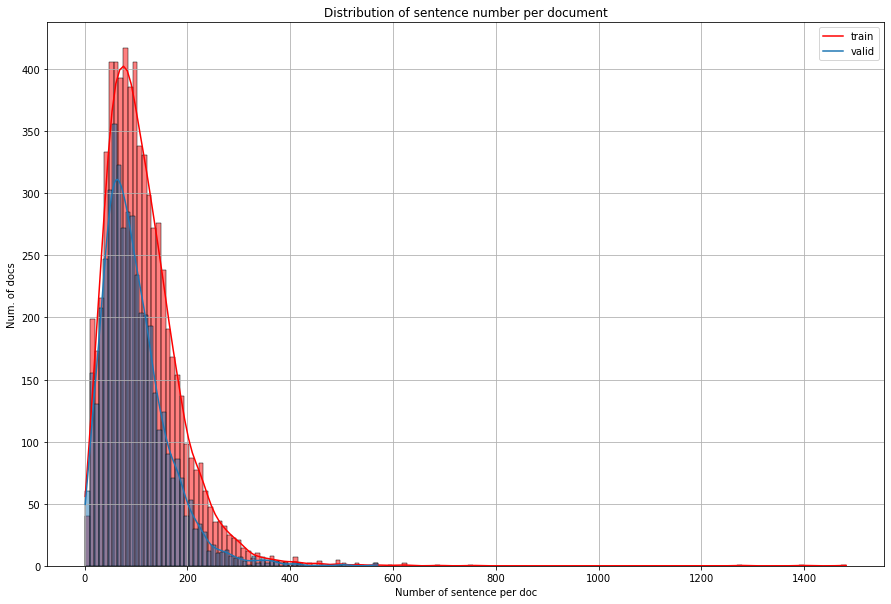

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Distribution of sentence number per document")
h = sns.histplot([len(i) for i in train_sents_per_doc], kde=True, color="red")
h = sns.histplot([len(i) for i in valid_sents_per_doc], kde=True)
h.set_ylabel("Num. of docs")
h.set_xlabel("Number of sentence per doc")
h.legend(labels=["train", "valid"])
plt.grid()
plt.show()

Как работает BPE токенизатор:

In [ ]:
# эти функции помогут нам сегментировать документы на предложения, токены и bpe-токены
from transformers import BertTokenizer  # BPE токенизация

In [ ]:
tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base', do_lower_case=False, max_len=10000)
print("====== TOKINIZER ======")
print(tokenizer)

Downloading:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/590 [00:00<?, ?B/s]

====== TOKINIZER ======
PreTrainedTokenizer(name_or_path='sberbank-ai/ruBert-base', vocab_size=120138, model_max_len=10000, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [ ]:
in_data = "Мама мыла раму окон от компании СберОкна"
print("====== INPUT DATA ======")
print(in_data)
print()
print("====== OUTPUT DATA ======")
print(tokenizer.tokenize("Мама мыла раму окон от компании СберОкна"))

====== INPUT DATA ======
Мама мыла раму окон от компании СберОкна

====== OUTPUT DATA ======
['Мама', 'мыла', 'раму', 'окон', 'от', 'компании', 'Сбер', '##О', '##к', '##на']


### 1.3.2. Количество BPE токенов на документ

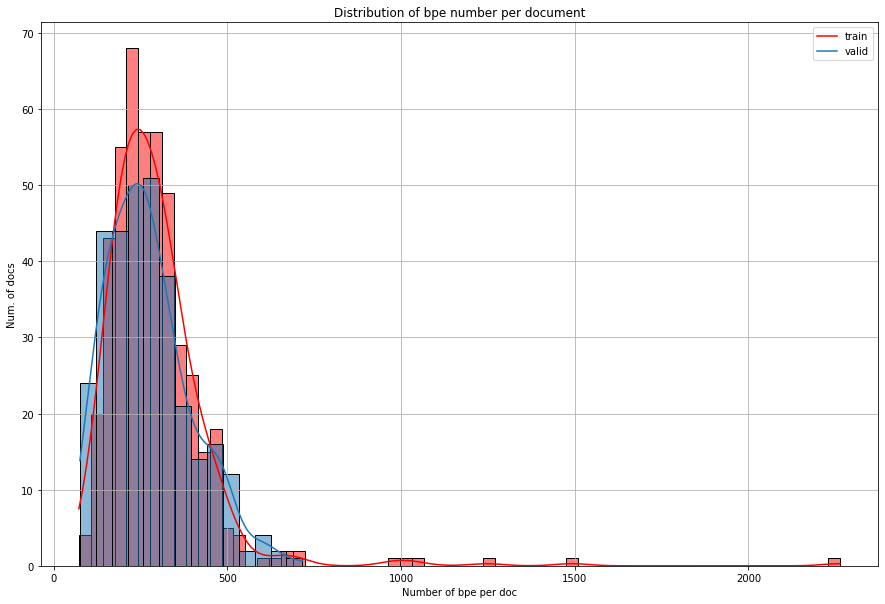

In [ ]:
train_bpe_per_docs = [tokenizer.tokenize(text) for text, _ in train_data]
valid_bpe_per_docs = [tokenizer.tokenize(text) for text, _ in valid_data]


plt.figure(figsize=(15,10))
plt.title("Distribution of bpe number per document")
h = sns.histplot([len(i) for i in train_bpe_per_docs], kde=True, color="red")
h = sns.histplot([len(i) for i in valid_bpe_per_docs], kde=True)
h.legend(labels=["train", "valid"])
h.set_ylabel("Num. of docs")
h.set_xlabel("Number of bpe per doc")
plt.grid()
plt.show()

#### Количество BPE токенов в предложениях

In [ ]:
train_bpe_per_sentence = [tokenizer.tokenize(sentence) for sentence in train_sents_per_doc]
valid_bpe_per_sentence = [tokenizer.tokenize(sentence) for sentence in valid_sents_per_doc]
test_bpe_per_sentence = [tokenizer.tokenize(sentence) for sentence in test_sents_per_doc]

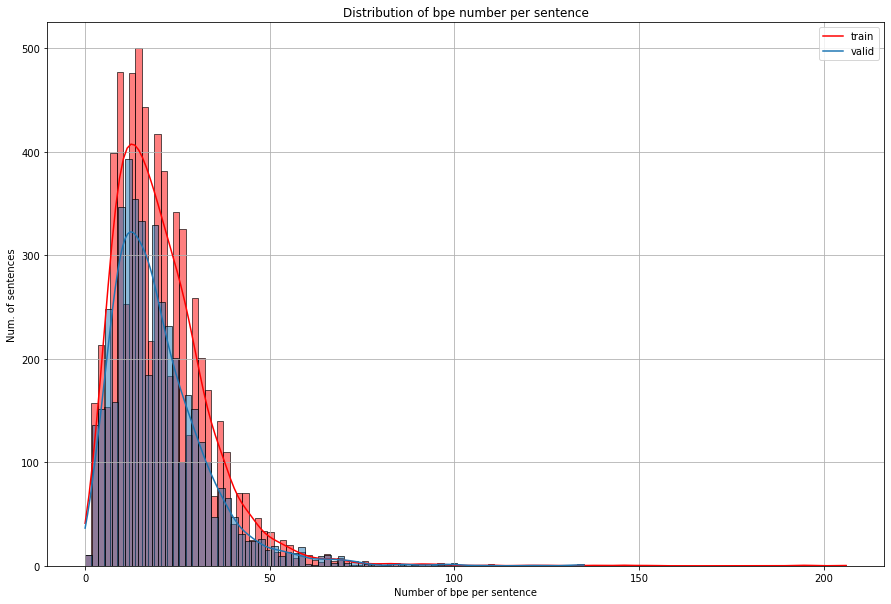

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Distribution of bpe number per sentence")
h = sns.histplot([len(i) for i in train_bpe_per_sentence], kde=True, color="red")
h = sns.histplot([len(i) for i in valid_bpe_per_sentence], kde=True)
h.legend(labels=["train", "valid"])
h.set_ylabel("Num. of sentences")
h.set_xlabel("Number of bpe per sentence")
plt.grid()
plt.show()

Теперь перейдем к тому, как вглядит разметка, так как именно соответствие текста и разметки -- залог обучения качественной модели.

#### Задача 1

Как много уникальных текстов сущностей есть в каждом наборе данных (относительно всех текстов сущностей в данном наборе): 

`set(train_entities)/list(train_entities)`. 

Функция принимает на вход список семплов из набора, возвращает чет уникальных текстов сущностей (без привязки к типу) и список всех текстов сущностей. Округлить до 3 символа.




In [ ]:
# Заготовка

def unique_entity_texts(dataset: List[Tuple[str, List[Tuple[int, int, str]]]]):
    ent_texts = [] 
    """
    Ваш код здесь
    """
    for text, ents in dataset:
      for ent_start, ent_end, ent_type in ents:
        ent_texts.append(text[ent_start : ent_end])
    unique_ent_texts = set(ent_texts)
    print(f"Entities in dataset: {len(ent_texts)}")
    print(f"Unique entity texts in dataset: {len(unique_ent_texts)}")
    print(f"Relation unique ent texts to all ent texts: {round(len(unique_ent_texts) / len(ent_texts), 3)}")
    return unique_ent_texts, ent_texts

In [ ]:
print("Train data")
unique_ent_texts_train, _ = unique_entity_texts(train_data)
print("\nValid data")
unique_ent_texts_valid, _ = unique_entity_texts(valid_data)
print("\nTest data")
unique_ent_texts_test, _ = unique_entity_texts(test_data)

Train data
Entities in dataset: 27743
Unique entity texts in dataset: 15831
Relation unique ent texts to all ent texts: 0.571

Valid data
Entities in dataset: 5594
Unique entity texts in dataset: 3908
Relation unique ent texts to all ent texts: 0.699

Test data
Entities in dataset: 5843
Unique entity texts in dataset: 4036
Relation unique ent texts to all ent texts: 0.691


##### Проверка

In [ ]:
unique_ent_texts, ent_texts = unique_entity_texts(train_data)
assert len(unique_ent_texts) == 15831, "Неверное количество уникальных текстов сущностей в тренировочном наборе"
assert len(ent_texts) == 27743, "Неверное количество сущностей в тренировочном наборе"

print("Good job")

Entities in dataset: 27743
Unique entity texts in dataset: 15831
Relation unique ent texts to all ent texts: 0.571
Good job


#### Задача 2

Какое количество уникальных текстов сущностей, присутствующих в валидационном и тестовом наборах, но не содержащихся в тренировочном? 

Функция принимает на вход три сета с уникальными наборами текстов сущностей, возвращает два значения intersection over union: между валидационной выборкой и тренировочной, между тестовой выборкой и тренировочной. Округлить до 4 символа

In [ ]:
# Заготовка
def iou(
    first_set: Set[str], 
    second_set: Set[str]
    ):
    """
    Ваш код здесь
    """
    return len(first_set & second_set) / len(first_set | second_set), first_set & second_set

def general_iou(
    unique_ent_texts_train: Set[str], 
    unique_ent_texts_valid: Set[str], 
    unique_ent_texts_test: Set[str]
    ):
    """
    Ваш код здесь
    """
    val_train_sc, val_train_inter = iou(unique_ent_texts_train, unique_ent_texts_valid)
    test_train_sc, test_train_inter = iou(unique_ent_texts_train, unique_ent_texts_test)

    return (
        round(val_train_sc, 4), 
        # val_train_inter,
        round(test_train_sc, 4), 
        # test_train_inter
    )

##### Проверка

In [ ]:
unique_ent_texts_train, _ = unique_entity_texts(train_data)
unique_ent_texts_valid, _ = unique_entity_texts(valid_data)
unique_ent_texts_test, _ = unique_entity_texts(test_data)

valid_train_iou, test_train_iou = general_iou(unique_ent_texts_train, unique_ent_texts_valid, unique_ent_texts_test)

assert valid_train_iou == 0.0535, "Неверное значение IOU для набора валидация vs трейн"
assert test_train_iou == 0.0542, "Неверное значение IOU для набора тест vs трейн"
print("Good job")

Entities in dataset: 27743
Unique entity texts in dataset: 15831
Relation unique ent texts to all ent texts: 0.571
Entities in dataset: 5594
Unique entity texts in dataset: 3908
Relation unique ent texts to all ent texts: 0.699
Entities in dataset: 5843
Unique entity texts in dataset: 4036
Relation unique ent texts to all ent texts: 0.691
Good job


## 1.4. Анализ разметки

### 1.4.1. Как пересекаются сущности?

- Есть сущности разных типов, которые не персекаются
- Есть сущности разных типов, которые персекаются
- Есть сущности одного и того же типа, которые пересекаются 

In [ ]:
show_span_line_markup(*train_data[0])

## 1.5. Схема теггирования

В задаче NER бывает несколько типов разметки
* **IO**: самая простая разметка. В ней токены делятся на два типа: 
    * **I**, Inside, токены, принадлежащие именованной сущности
    * **O**, Outside, токены, не входящие в именованную сущность
Ограничение: нельзя корректно соединить несколько последовательных слов, из которых состоит одна именованная сущность.

* **BIO**: более продвинутая разметка. Токены делятся на три типа:
    * **B**, Beginning, токены, с которых начинается именованная сущность
    * **I**, Inside, токены, которые входят в именованную сущность, но с них именованная сущность не начинается
    * **O**, Outside, токены, которые не входят в именованную сущность
При помощи этого типа разметки можно решить проблему с именованными сущностями, состоящими из нескольких слов.

[More info](https://www.sciencedirect.com/science/article/pii/S1110866520301596)



<figure>
<center>
<img src='https://devopedia.org/images/article/256/4681.1580659482.png' />
<figcaption>The examples of tagging according to different schemes </figcaption></center>
</figure>



### Задача 3
Определите класс, который умеет конвертировать исходную разметку в BIO схему теггирования и обратно.

Нужно реализовать три метода:

**markup2scheme** - принимает на вход кортеж из токенов и исходной разметки со спанами, возвращает токены и список с лейблами на каждый токен

**scheme2markup** - принимает на вход кортеж из токенов и лейблов на каждый токен, возвращает токены и разметку ввиде спанов

**run** - выполняет один из методов выше, в соответствии с флагом

In [ ]:
# Заготовка

class BIOMarkuper:

    def __init__(self, out_value: str = "O"):
        self.out_value = out_value

    def markup2scheme(
        self, 
        input_sample: Tuple[
                        List[Tuple[int, int, str]], # tokens
                        List[Tuple[int, int, str]]  # entities
                      ]
    ) -> Tuple[List[str], List[str]]:
      """
      Умеет преобразовывать исходный пример в виде токенов (с координатами) и списка сущностей 
      в экземпляр обучения, то есть список токенов и список лейблов, составеленных в соответствии с BIO схемой.
      """
      tokens, entities_chars = input_sample
      ents = self.char2token_markup(tokens, entities_chars)
      scheme = [self.out_value] * len(tokens)
      for start, end ent_type in ents:
        scheme[start] = f'B_{ent_type}'
        n_i_tags = end - start - 1
        scheme[start+1 : end] = f'I_{ent_type}'*n_i_tags
      return (tokens, scheme)
      
    def char2token_markup(
        self, 
        tokens: List[Tuple[int, int, str]], 
        ents: List[Tuple[int, int, str]]
    ) -> List[Tuple[int, int, str]]:
      """
      Маппит символьные координаты для каждой сущности в токенных.
      """
      up_ents = []
      for start, end, ent_type in ents:
        tes, tee = None, None
        for ti, (ts, te, token) in enumerate(tokens):
          if ts <= start < te:
            tes = ti
            continue
          if ts < end  <= te:
            tee = ti + 1
            continue
        if tes in not None and tee is not None:
          up_ents.append((tes, tee, ent_type))
      return  up_ents
    
    def scheme2markup(
        self,
        output_sample: Tuple[List[str], List[str]]
    ) -> Tuple[List[str], List[Tuple[int, int, str]]]:
      """
      Умеет преобразовывать экземпляр обчения в виде токенов (с координатами) и списка лейблов, составеленных в соответствии с BIO схемой 
      в исходный пример, то есть список токенов и спискок сущностей с символьными координатами.
      """
      tokens, scheme = output_sample
      markup = []
      current_entity = None
      for i_tag, tag in enumerate(scheme):
        if tag = self.out_value:
          if not current_entity:
            continue
          current_entity = (current_entity[0], i_tag, current_entity[0])
      return 

    def token2char_markup(
        self, 
        tokens: List[Tuple[int, int, str]], 
        ents: List[Tuple[int, int, str]]
    ) -> List[Tuple[int, int, str]]:
      """
      Маппит токенные координаты для каждой сущности в символьные.
      """
      pass

    def run(self, 
            sample: Union[
                            Tuple[ # input_semple
                                List[Tuple[int, int, str]], # tokens
                                List[Tuple[int, int, str]]  # entities
                            ],
                            Tuple[
                                List[Tuple[int, int, str]], # tokens
                                List[str]  # scheme
                            ]
                          ],
            direction: str):
      """
      Запускает конвертацию одного примера в нужном направлении.
      """
      pass

#### Проверка

In [ ]:
tokens = [(0, 6, "Иванов"), (7, 11, "Иван"), (12, 18, "поедет"), (19, 20, "в"), (21, 26,"Санкт"), (26, 27,"-"), (27, 36, "Петербург")]
entities = [(0, 11, "PER"), (21, 36, "LOC")]
scheme = ["B_PER", "I_PER", "O", "O", "B_LOC", "I_LOC", "I_LOC"]

input_sample = (tokens, entities)
output_sample = (tokens, scheme)
markuper = BIOMarkuper()


result = markuper.run(input_sample, "m2s")
assert output_sample == result,  "Incorrect convertion to the scheme"
result = markuper.run(output_sample, "s2m")
assert input_sample == result,  "Incorrect convertion to the markup"
print("Good job")

## 1.6. Упрощаем задачу

Пересечения -- это проблема. Потому что нужно, чтобы модель имела возможность предсказывать сразу несколько именованных сущностей, причем, возможно, одного класса.

Поэтому, как и говорилось выше, решать сразу соревнование RuNNE мы не будем. Вместо этого мы возьмем только две базовых сущности, у которых нет вложенности и нет пересечения. 

Итоговая задача будет выглядеть следующим образом: 
1. Будем работать только в пределах предложений - производим сегментацию.
2. Разметку нужно обработать - раньше координаты начала и конца были на уровне документов, а нам нужны на уровне предложений.
3. Удаляем сущности все сущности с типом отличным от **PERSON**, **ORGANIZATION**. Распознавать будем только эти сущности.

Эти операции проделает код, который приведен ниже. Он очень прост с точки зрения реализации, поэтому можете просто ознакомиться с тем, что в нем происходит или пропустить, если вы понимаете, как реализовать преобразования выше.

In [ ]:
from utils import shift_entities

def add_markup_to_each_sentence(data: list):
    flatten_data_with_shift_ents = []
    for document_text, markup in data:
        sentences_infos = sentence_segmentation([document_text], True)
        ent_per_sents = shift_entities(sentences_infos, markup)
        for sent_info, sent_ent, in zip(sentences_infos, ent_per_sents):
            flatten_data_with_shift_ents.append((sent_info, sent_ent))
    return flatten_data_with_shift_ents

train_sentence_samples = add_markup_to_each_sentence(train_data)
print()
valid_sentence_samples = add_markup_to_each_sentence(valid_data)
print()
test_sentence_samples = add_markup_to_each_sentence(test_data)


Entity (566, 607, 'ORGANIZATION') was skipped due to incorrect segmentation in sentence #(4, 'Связано это с тем, что над его разрешением каждая в своих интересах работают три силы: правительственная правоконсервативная коалиция с ведущей двойкой партий - Гражданская демократическая партия (ODS), "Традиция.')
Entity (2648, 2671, 'ORGANIZATION') was skipped due to incorrect segmentation in sentence #(19, '«Мы дали ему четко понять, что ему придется заработать место в основной команде», – цитирует слова Армстронга главная газета Сент-Луиса St.')
Entity (2648, 2657, 'CITY') was skipped due to incorrect segmentation in sentence #(19, '«Мы дали ему четко понять, что ему придется заработать место в основной команде», – цитирует слова Армстронга главная газета Сент-Луиса St.')
Entity (783, 806, 'ORGANIZATION') was skipped due to incorrect segmentation in sentence #(8, 'Газета St.')

Entity (159, 170, 'WORK_OF_ART') was skipped due to incorrect segmentation in sentence #(2, 'Первый канал аннули

In [ ]:
for (_, _, text), markup in train_sentence_samples[:4]:
  show_span_line_markup(text, markup)
  print()

In [ ]:
from utils import filter_entities

needed_ents = {'PERSON', 'ORGANIZATION'}
valid_sentence_samples = filter_entities(valid_sentence_samples, needed_ents)
train_sentence_samples = filter_entities(train_sentence_samples, needed_ents)
test_sentence_samples = filter_entities(test_sentence_samples, needed_ents)

Посмотрим сколько у нас примеров в каждой из выборок:

In [ ]:
print(f"Train samples: {len(train_sentence_samples)}")
print(f"Valid samples: {len(valid_sentence_samples)}")
print(f"Test samples: {len(test_sentence_samples)}")

Train samples: 6509
Valid samples: 4458
Test samples: 1493


Модель будем обучать и валидировать только на примерах, в которых есть сущности, это также наше упрощение задачи.

In [ ]:
train = [i for i in train_sentence_samples if i[1]]
valid = [i for i in valid_sentence_samples if i[1]] 
test = [i for i in test_sentence_samples if i[1]] 
print(f"Train samples: {len(train)}")
print(f"Valid samples: {len(valid)}")
print(f"Test samples: {len(test)}")


Train samples: 4299
Valid samples: 848
Test samples: 909


Мы подготовили данные так, чтобы они были удобны для обучения нейронной сети.

## 1.7 Подготовка DataLoader

Для этого нам понадобятся стандартные `torch` инстурменты: `Dataset` и `DataLoader`.

### 1.7.1. Dataset


  1. Определяем паддинги (токен и индекс) и максимальную длину последовательности в соответствии с моделью
  2. Инициализируем два токенизатора: токенный - `WordPunctTokenizer`, bpe - `BertTokenizer`, то есть будем сначала разбивать предложения на токены, а потом токены на bpe.
  3. При инициализации класса готовим для каждого примера  тензорное представление


Как мы приводим к тензорному представлению:

- Сегментируем на токены исходные предложения. 
- Маппим символьные спаны сущностей на метки токенов. 
	
```
tokens = ["Мама" , "мыла", "раму", "окон", "фирмы", "СберОкна"]
token_labels = ["O" , "O", "O", "O", "O", "ORGANIZATION"]
```
- Токенизируем токены на bpe части и конвертируем их в индекс в соответствии с индексом хранящимся в BertTokenizer. При этом если из одного токена мы получается несколько bpe мы расширяем список с labels:

```
bpe_tokens = ["Сбер", "##О", "##к", "##н"]
input_ids = [86, 13, 10003, 65999]
labels = [2, 2, 2, 2, 2]
token_start_mask_id = [2, -100, -100, -100, -100]
```
- `labels` будем использовать для обучения и считать по ним лосс, а - `token_start_mask_id` - для конвертации предсказаний моедли, метка токена (тип сущности) будет сниматься только с первого bpe токена.



Один из основных классов в нашей тетрадке `CustomDataset`. У нас есть примеры, которые мы уже довольно хорошо изучили.
Теперь нам нужно понять как их подавать в модель. И тут небольшая подсказка `BERT-like` модели ожадают на вход как минимум
`"input_ids"`, `"attention_mask"`, `"labels"` для обучения. В процессе реализации CustomDataset, вы поймете, что есть что.

#### Задача 4.
Создание "ленивого" (вполовину) загрузчика данных - имплементация класса `CustomDataset`.

In [ ]:
# Заготовка

class CustomDataset(Dataset):

    def __init__(
            self, 
            samples: list, 
            out_label: str = "O", 
            max_seq_len: int = 512,
            pad_index: int = -100

    ):

        self.out_label = out_label
        self.max_seq_len = max_seq_len
        self.pad_index = pad_index


        # в первом эксперименте мы будем использовать IO схему теггирования, 
        # если немного поразмышлять, то поймем - IO схема, значит что никаких префиксов к типам сущностей мы можем и не добавлять
        labels = [out_label, 'PERSON', 'ORGANIZATION']
        self.label_to_id = {label: index for index, label in enumerate(labels)}

        self.tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base', max_len=10000)
        # так как интерфейс tokenizers в HF одинаковый, то вы сможете легко попробовать и другие модели
        # self.tokenizer = RobertaTokenizerFast.from_pretrained('blinoff/roberta-base-russian-v0', max_len=10000)

        self.tokens_per_sample, self.data = [], []

        self.wpt = WordPunctTokenizer()

        for sentence_info, markup in tqdm(samples):
            sample_tensors, tokens_positions = self.prepare_sentence(
                sentence_info, markup, self.wpt.span_tokenize
            )
            self.data.append(sample_tensors)
            self.tokens_per_sample.append(tokens_positions)

    def prepare_sentence(
          self, sentence_info: tuple, ents: list, tokenize_fn: Callable
    ) -> Tuple[Dict[str, torch.tensor], List[Tuple[int, int, str]]]:
        """
        Задача:
        1. Разбить текст входного предложения на токены с координатами, то есть
            реализовать метод tokenize_sentence

        2. Подготовить список лейблов (на каждый токен):
            - сначала проинициализируйте все падами
            - потом заполните пады реальными лейблами: для этого используйте
              координаты токенов и координаты сущностей в символах
            то есть реализуйте метод convert_span2labels
        3. Инициализируем списки labels_ids, token_start_mask со значением -100
        4. Инициализируем tokens_ids с одним элементом - индекс токена CLS (используйте 
            метод convert_tokens_to_ids у BPE токенизатора)

        5. Идем циклом сразу по двум спискам токены и лейблы
            - токен разбиваем на bpe
            - переводим bpe в индексы
            - добавляем в список tokens_ids
            - конвертируем лейбл в индекс и дублируем столько раз,
              сколько получилось бпе в токене
            - добавляем в список labels_ids
            - создаем на каждый токен token_start_mask_id,
              где первый элемент индекс лейбл, а остальные -100 (будем потом 
                  использовать для конвертации и расчета метрик)
            - добавляем список token_start_mask_id к token_start_mask 

        6. Паддим до максимальной длины или обрезаем списки
        7. Конвертируем в тензора и собираем тензора в словарь

        """
        s_start, s_end, sentence = sentence_info

        tokens_per_sample = self.tokenize_sentence(sentence, tokenize_fn)

        labels = self.convert_span2labels(self.out_label, ents, tokens_per_sample)

        """
        Ваш код здесь
        """
        labels_ids = [self.pad_index]
        token_start_mask = [self.pad_index]
        token_ids = self.tokenizer.convert_tokens_to_ids(['CLS'])

        for (_, _, token_text), label in zip(tokens_per_sample, labels):
          bpes = self.tokenizer.tokenize(token_text)
          if not bpes:
            bpes = ['[UNK]']
            token_ids.extend(self.tokenizer.convert_tokens_to_ids(bpes))
          else:
            token_ids.extend(self.tokenizer.convert_tokens_to_ids(bpes))
          
          token_label_ids = [self.label_to_id[label]]
          token_start_mask_id = [self.label_to_id[label]]

          if len(bpes) > 1:
            token_label_ids.extend([self.label_to_id[label]] * (len(bpes) - 1))
            token_start_mask_id.extend([self.pad_index] * (len(bpes) - 1))
        
          labels_ids.extend(token_label_ids)
          token_start_mask.extend(token_start_mask_id)

        if len(token_ids) >= self.max_seq_len:
          return {
                'input_ids' : torch.as_tensor(token_ids[:self.max_seq_len], dtype=torch.int64),
                'attention_mask' : torch.as_tensor([1]*self.max_seq_len, dtype=torch.float32),
                'labels' : torch.as_tensor(labels_ids[:self.max_seq_len], dtype=torch.int64),
                'token_start_mask' : torch.as_tensor(token_start_mask[:self.max_seq_len], dtype=torch.int64)
                }, tokens_per_sample

        pad = self.max_seq_len - len(token_ids)
        return {
                'input_ids' : torch.as_tensor(token_ids + [0]*pad, dtype=torch.int64),
                'attention_mask' : torch.as_tensor([1]*len(token_ids) + [0]*pad, dtype=torch.float32),
                'labels' : torch.as_tensor(labels_ids + [-100]*pad, dtype=torch.int64),
                'token_start_mask' : torch.as_tensor(token_start_mask + [-100]*pad, dtype=torch.int64)
                }, tokens_per_sample


    @staticmethod
    def tokenize_sentence(sentence: str, tokenize_fn: Callable):
        """
        На вход ожидается предложение и функция для токенизация,
        а на выходе список из туплов с информацией о расположении токенов
        
        Я иду домой -> (0, 1, я) (2, 5, иду) (6, 11, домой)
        
        """
        tokens_per_sample = []
        """
        Ваш код здесь
        """
        start_token = 0
        for start, end in tokenize_fn(sentence):
          token = sentence[start:end]
          tokens_per_sample.append((start, end, token))

        return tokens_per_sample

    @staticmethod
    def convert_span2labels(
            out_label: str, ents: list, tokens_per_sample: list
    ):
        """
        На вход ожидается значение out_label токена, список сущностей и
        список токенов с мета информацией. Пересекаем здесь сущности
        по координатам с токенами и возвращемс список лейблов.
        Количество лейблов должно быть равно количеству токенов.
        """
        labels = [out_label] * len(tokens_per_sample)
        """
        Ваш код здесь
        """
        for start_ents, end_ents, ent in ents:
            ind = 0
            for start_t, end_t, token in tokens_per_sample:
                if start_ents <= start_t and end_t <= end_ents:
                    labels[ind] = ent        
                ind += 1
        return labels

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [ ]:
# Проверка
test_sample = [
    (
        (0, 36,"Иванов Иван поедет в Сбербанк"), [(0, 11, "PERSON"), (21, 29, "ORGANIZATION")]
     )
]

assert_cd = CustomDataset(test_sample, max_seq_len=15)

first_prepared_sentence = assert_cd.data[0]

print("=" * 40)

print("input_ids: \n", first_prepared_sentence["input_ids"], "\n")
print("attention_mask: \n", first_prepared_sentence["attention_mask"], "\n")
print("labels: \n", first_prepared_sentence["labels"], "\n")
print("token_start_mask: \n", first_prepared_sentence["token_start_mask"], "\n")


assert torch.equal(first_prepared_sentence["input_ids"], torch.tensor([100, 104691, 823, 104691, 379, 31888, 113,  83492, 9635, 0, 0, 0, 0, 0, 0]))
assert torch.equal(first_prepared_sentence["attention_mask"], torch.tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]))
assert torch.equal(first_prepared_sentence["labels"], torch.tensor([-100, 1, 1, 1, 1, 0, 0, 2, 2, -100, -100, -100, -100, -100, -100]))
assert torch.equal(first_prepared_sentence["token_start_mask"], torch.tensor([-100, 1, -100, 1, -100, 0, 0, 2, -100, -100, -100, -100,-100, -100, -100]))

print("=" * 40)

print("good job")

  0%|          | 0/1 [00:00<?, ?it/s]

input_ids: 
 tensor([   100, 104691,    823, 104691,    379,  31888,    113,  83492,   9635,
             0,      0,      0,      0,      0,      0]) 

attention_mask: 
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]) 

labels: 
 tensor([-100,    1,    1,    1,    1,    0,    0,    2,    2, -100, -100, -100,
        -100, -100, -100]) 

token_start_mask: 
 tensor([-100,    1, -100,    1, -100,    0,    0,    2, -100, -100, -100, -100,
        -100, -100, -100]) 

good job


Инциализируем датасеты для всех набором и посмотрим как в тензорном виде выглядит один пример для обучения:

In [ ]:
MAX_SEQ_LEN = 256
train_ds = CustomDataset(train, max_seq_len=MAX_SEQ_LEN)
valid_ds = CustomDataset(valid, max_seq_len=MAX_SEQ_LEN)
test_ds = CustomDataset(test, max_seq_len=MAX_SEQ_LEN)

  0%|          | 0/4299 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

### 1.7.2. Dataloader

In [ ]:
NUM_WORKERS = 2
train_dl = DataLoader(train_ds, batch_size=16, num_workers=NUM_WORKERS)
valid_dl = DataLoader(valid_ds, batch_size=16, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_ds, batch_size=16, num_workers=NUM_WORKERS, shuffle=False)

# 2. Модель

## 2.1. Подготовка модели и Lightning модуля

 ### Основная модель: [BertForTokenClassification](https://github.com/huggingface/transformers/blob/v4.21.3/src/transformers/models/bert/modeling_bert.py#L1709)

<figure>
<center>
<img src='https://d2l.ai/_images/bert-tagging.svg'/>
</center>
</figure>


<br>

### Что именно инициализируется и как?

```python
class BertForTokenClassification(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()
```
### А что еще реализовано за нас?

```python
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
```

 ### Self-attention

А теперь давайте разберемся, как работает механизм внимание. Для этого нам нужно создать несколько тензоров размерностью:
- размер батча 
- длина последовательности 
- размером эмбеддингов 

После этого имплементируем механизм внимание, представленный в оригинальной статье.

Шаги:


- Инициализируем линейные преобразования
- Инициализируем входную последовательность
- Преобразуем входную последовательность

In [ ]:
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

input_sequence = torch.rand(10, 15, 20)

k = nn.Linear(20, 17)
q = nn.Linear(20, 17)
v = nn.Linear(20, 17)

key = k(input_sequence)
query = q(input_sequence)
value = v(input_sequence)

- Получем attention_scores
- Производим скейлинг последовательности

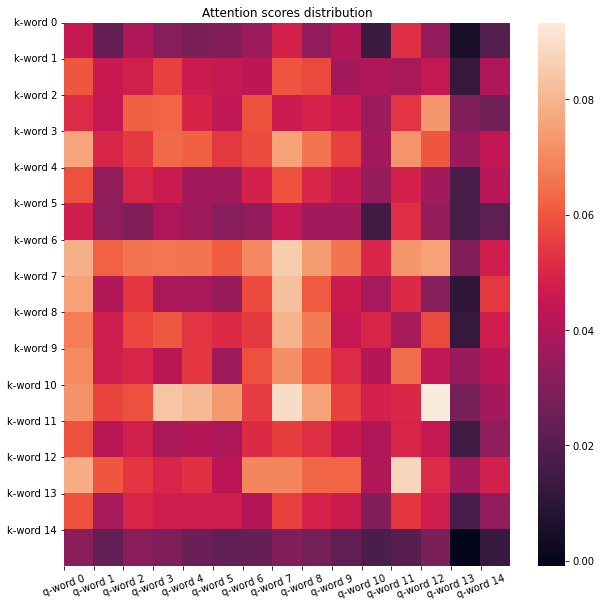

In [ ]:
attention_scores = torch.bmm(query, key.transpose(1, 2)) / key.size(-1)

plt.figure(figsize=(10,10))

sns.heatmap(attention_scores[0].detach().numpy())

plt.title("Attention scores distribution")
plt.yticks(range(15), (f"k-word {i}" for i in range(15)), rotation=0)
plt.xticks(range(15), (f"q-word {i}" for i in range(15)), rotation=20)
plt.show()

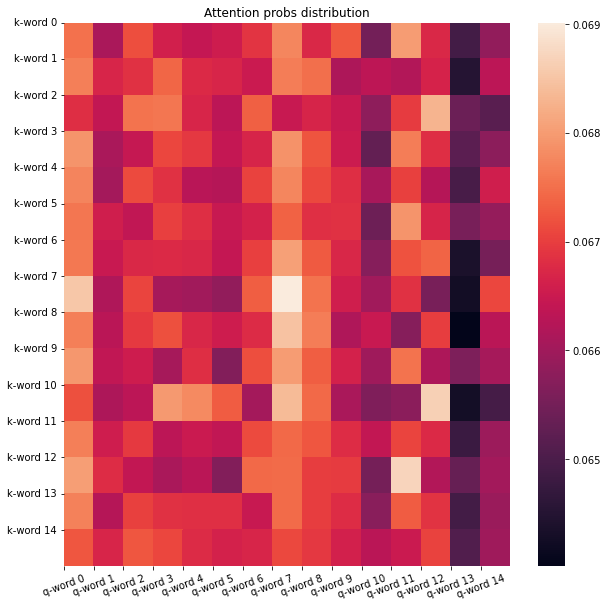

In [ ]:
attn_probs = F.softmax(attention_scores, -1)

plt.figure(figsize=(10,10))

sns.heatmap(attn_probs[0].detach().numpy())

plt.title("Attention probs distribution")
plt.yticks(range(15), (f"k-word {i}" for i in range(15)), rotation=0)
plt.xticks(range(15), (f"q-word {i}" for i in range(15)), rotation=20)
plt.show()

- получаем сontetualized embeddings

In [ ]:
contextulized_embeddings = torch.bmm(attn_probs, value)

<figure>
<center>
<img src='https://i.pinimg.com/originals/f9/ec/d9/f9ecd9df0dda3b85b93e19364ec1618e.jpg' />
</center>
</figure>




In [ ]:
import pytorch_lightning as pl


class NERModel(pl.LightningModule):

    def __init__(self, num_labels: int = 3):

        super().__init__()

        # self.model = RobertaForTokenClassification.from_pretrained('blinoff/roberta-base-russian-v0', num_labels=3)
        # Готовая модель из transofomers
        self.model = BertForTokenClassification.from_pretrained('sberbank-ai/ruBert-base', num_labels=num_labels)

        # Сюда будем складвать данные по бачам из валидации, чтобы в конце эпохи рассчитать метрики
        self.data_to_eval = []

        self.index2label = {0: "O", 1: 'PERSON', 2:'ORGANIZATION'}

    def training_step(self, batch, batch_idx):

        out = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
            )
        
        self.log('train_loss', out.loss)

        return out.loss

    def validation_step(self, batch, batch_idx):

        out = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
            )
        
        self.log('val_loss', out.loss)
        logits = out.logits.argmax(dim=-1)

        self.data_to_eval.append(
            (logits.cpu().numpy(), batch["token_start_mask"].cpu().numpy())
        )

    def on_validation_end(self) -> None:        
        self.count_metrics()
        self.data_to_eval = []

    def count_metrics(self):
      
      flat_preds, flat_target = [], []
      for preditions, targets in self.data_to_eval:
        for sample_pred, sample_target in zip(preditions, targets):
          for index, s_t in enumerate(sample_target):
            if s_t != -100:
              flat_target.append(s_t)
              flat_preds.append(sample_pred[index])
      
      report = classification_report(
          flat_target, flat_preds, target_names = ['O','PERSON','ORGANIZATION'], output_dict = True
      )
      for key_report in report:
        if key_report == "accuracy":
          continue
        self.trainer.logger.experiment.log(
          {f"F1-score: {key_report.upper()}": report[key_report]["f1-score"]}
        )
        print(f"F1-score - {key_report.upper()} : {report[key_report]['f1-score']}")
      print()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-6)
        return optimizer

    def predict(self, predict_dl: DataLoader):
      self.eval()
      preds = []
      with torch.no_grad():
        for batch in predict_dl:
          batch = {k: v.to(self.device) for k, v in batch.items()}
          out = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
            )
          predictions = out.logits.argmax(dim=-1).cpu().numpy()
          preds.extend(
              self.format_predictions(predictions, batch["token_start_mask"])
              )
      return preds
          
    def format_predictions(self, predictions: torch.tensor, tokens_mask: torch.tensor):
      """
      Метод предназначен для создания лейблов из предсказанных логитов модели.
      У нас есть тензор-маска - tokens_mask. Используем значение -100, чтобы только 
      с этих токенов снимать лейблы. Остальные логиты нас не интересуют. Поясню:
      
      С чем работает модель:
      BPE         [Абра #кад #абра искомое слово]
      predictions [2    2   2    0      0   ]
      tokens_mask [-100 0   0    -100   -100]

      С чем хотим работать мы:
      Токены       [Абракадабра    искомое слово]
      labels      [2             0      0   ]

      """
      batch_preds = []
      for pred, mask in zip(predictions, tokens_mask):

        batch_preds.append(
            [self.index2label[pred[i_m]] for i_m, mask_value in enumerate(mask) if mask_value != -100]
        )
      return batch_preds
          
              

In [ ]:
m = NERModel()

Downloading:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized fr

# 3. Процесс обучения модели

Теперь мы готовы к обучению.

Из того, что нам обязательно стоит сделать: 

1.   Инициализировать инстурмент трекинга экспериментов - мы продолжим работать с `WandbLogger`
2.   Инициализировать инстурмент сохранения чекпоинтов, который позволит там сохранять лучшие веса моделей - `ModelCheckpoint`


Поставим всего 5 эпох обучения - задача у нас довольно простая, данных достаточно для дообучения модели.



In [ ]:
!mkdir check_points

y


In [ ]:
import os
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

logs_dir = "logs"
project_name = "sber-td-course"
exp_name = "ruBert-base-v2"


os.environ['WANDB_API_KEY'] = open('/content/drive/MyDrive/ssh/wandbkey.txt').read().strip()
logger = WandbLogger(
    save_dir=logs_dir,
    project=project_name,
    name=exp_name,
)

# для простоты будем мониторить лосс и по нему сохранять чекпоинты
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./check_points",
    filename="runne_ner-{epoch:02d}-{val_loss:.4f}",
    save_top_k=2,
    mode="min",
)

trainer = pl.Trainer(
    num_sanity_val_steps=0, 
    gpus=[0], 
    max_epochs=5, 
    logger=logger,
    callbacks=[checkpoint_callback]
)

trainer.fit(m, train_dl, valid_dl)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | BertForTokenClassification | 177 M 
---------------------------------------

Training: 0it [00:00, ?it/s]

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nosenkoartyom1989. Use `wandb login --relogin` to force relogin
wandb: WARNING Path logs/wandb/ wasn't writable, using system temp directory.


Validation: 0it [00:00, ?it/s]

F1-score - O : 0.9811964544004748
F1-score - PERSON : 0.9465322334249924
F1-score - ORGANIZATION : 0.8025531914893617
F1-score - MACRO AVG : 0.9100939597716096
F1-score - WEIGHTED AVG : 0.9650198025636052



Validation: 0it [00:00, ?it/s]

F1-score - O : 0.9862882063791255
F1-score - PERSON : 0.9586571339757538
F1-score - ORGANIZATION : 0.8520761245674742
F1-score - MACRO AVG : 0.9323404883074512
F1-score - WEIGHTED AVG : 0.973977482694317



Validation: 0it [00:00, ?it/s]

F1-score - O : 0.9873305507332027
F1-score - PERSON : 0.9612643321970871
F1-score - ORGANIZATION : 0.8626421697287839
F1-score - MACRO AVG : 0.9370790175530246
F1-score - WEIGHTED AVG : 0.9758541595429394



Validation: 0it [00:00, ?it/s]

F1-score - O : 0.9878228782287822
F1-score - PERSON : 0.9602484472049689
F1-score - ORGANIZATION : 0.8658428949691086
F1-score - MACRO AVG : 0.9379714068009534
F1-score - WEIGHTED AVG : 0.9763901496550881



Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


F1-score - O : 0.9875666074600356
F1-score - PERSON : 0.9608518634512997
F1-score - ORGANIZATION : 0.8661882650907556
F1-score - MACRO AVG : 0.9382022453340303
F1-score - WEIGHTED AVG : 0.9762620014692903



In [ ]:
!ls check_points

'runne_ner-epoch=02-val_loss=0.1009.ckpt'
'runne_ner-epoch=03-val_loss=0.1035.ckpt'


# 4. Инференс модели

Для инференса нам потребуется:
1. Загрузить лучшую (по нашему мнению модель)
2. Подготовить тестовый набор, то есть инициализируем **CustomDataset** и **Dataloader** (что уже сделали)
3. Определить метод трансформации логитов в метки, а затем восстановление исходных символьных координат


## 4.1. Загрузка модели из checkpoint

Находим лучшую модель из последнего запуска обусения встроенным функционалом checkpoint_callback

In [ ]:
best_model_path = checkpoint_callback.best_model_path
best_model_path

'/content/check_points/runne_ner-epoch=02-val_loss=0.1009.ckpt'

In [ ]:
model = NERModel.load_from_checkpoint(best_model_path)

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized fr

Ура! Наша модель успешно загружена. Всплывающий ворнинг говорит нам только о том, что в процессе загрузки мы сначала загрузили исходные веса `BERT` и в них нех ватило параметров, чтобы проинициализировать классификационную голову, но затем поверх них загрузились результирующие веса затюненой модели. Напомню, что загрузка претренированных весов (без головы) выполнялась этим кодом:

`self.model = BertForTokenClassification.from_pretrained('sberbank-ai/ruBert-base', num_labels=num_labels)`


## 4.2. Преобразование сигналов в результат

Осталось научиться преобразовывать логиты в символьные спаны, то есть привести предсказания модели к виду исходной разметки.

Для этого нам понадобится две сущности:



1.   Экземпляр класса `CustomDataset`. Он содержит в себе информацию о токенах и их позициях в исходном тексте.
2.   Логиты модели, чтобы получи соответствующий лейбл для каждого токена.






In [ ]:
def transform_logits_to_char_spans(dataset: CustomDataset, logits: torch.tensor):


  transfomed_predictions = []

  # Проверим что количество предсказаний и количество исходных примеров совпадают
  assert len(dataset.tokens_per_sample) == len(logits), "len(dataset.tokens_per_sample) != len(logits)"


  # Итерируемся по предложению (разбито на токены) и логитам
  for sample, markup in zip(dataset.tokens_per_sample, logits):

    # Для каждого предложения будем собирать исходный текст из окенов и позиций
    text_sample = [" "] * sample[-1][1]
    # Здесь будут храниться символьные координаты сущностей
    char_coords = []

    prev_ent = None
    
    # Итерируемся по токенам и лейблам для того, чтобы перейти от потокенной классификации к символьным спанам
    for (s, e, token), label in zip(sample, markup):
        text_sample[s:e] = list(token)

        # Если предсказанный лейбл == "O", обрабатываем две ситуации: 
        #  - Завершаем создание некоторого спана, то есть сущности
        #  - Пропускаем токен
        if label == "O":
          if prev_ent:
            char_coords.append(prev_ent)
          prev_ent = None
          continue

        # Если предсказанный лейбл != "O", обрабатываем две ситуации: 
        #  - Обновляем существующий спан, продлеваем его на один токен вправо
        #  - Начинаем создавать новый спан
        if prev_ent:
          if label != prev_ent[-1]:
            char_coords.append(prev_ent)
            prev_ent = s, e, label
            continue
          if label == prev_ent[-1]:
            prev_ent = prev_ent[0], e, prev_ent[-1]
            continue

        if prev_ent is None:
          prev_ent = s, e, label
          continue

    # Не забываем обработать последний токен
    if prev_ent:
      if label != prev_ent[-1]:
        char_coords.append(prev_ent)
        char_coords.append((s, e, label))
      if label == prev_ent[-1]:
        char_coords.append((prev_ent[0], e, prev_ent[-1]))

    # Склеиваем тексты из токенов, которые мы собирали
    transfomed_predictions.append((''.join(text_sample), char_coords)) 
   
  return transfomed_predictions

## 4.3. Собираем все вместе

In [ ]:
def inference_model(
    model: nn.Module, 
    device: str, 
    dataset: CustomDataset, 
    dataloader: DataLoader
  ) -> List[Tuple[str, list]]:
  """
  Переносим модель на девайс
  Выполняем предикт с помощью модели
  Преобразуем логиты в символьные спаны
  """
  model = model.to(device)
  logits = model.predict(dataloader)
  return transform_logits_to_char_spans(dataset, logits)

In [ ]:
result = inference_model(
    model, 
    "cuda:0", 
    test_ds, 
    test_dl
  )

In [ ]:
for sample_predictions in result[:10]:
  show_span_line_markup(*sample_predictions)
  print()

## 4.4. Анализ ошибок 


Для выполнения анализа ошибок нам потребуется определить еще несколько методов. Мы будем искать несовпадения в спанах и визулизировать только их, таким образом мы сможем понять:
1. Есть ли у модели проблемы с предсказанием сущностей из-за разрыва, то есть может ли модель в спане из трех токенов не отнести средний к сущности
2. Есть ли у нас over-/under- предикт.

In [ ]:
from collections import Counter


def get_lists_diff(a: list, b: list) -> Tuple[list, list]:
    a_counter = Counter(a)
    b_counter = Counter(b)
    only_a = (a_counter - b_counter).elements()
    only_b = (b_counter - a_counter).elements()
    return list(only_a), list(only_b)


def get_spans_diff(
        gold_spans: List[tuple], predicted_spans: List[tuple]
) -> List[tuple]:
    only_gold, only_predicted = get_lists_diff(gold_spans, predicted_spans)
    spans = [(start, end, "G_" + type) for start, end, type in only_gold]
    spans.extend([(start, end, "P_" + type) for start, end, type in only_predicted])
    return spans


def visualize_difference(target_samples, 
             predictoons, 
             n_samples = 10, 
             ):
  for target_markup, predition in list(zip(test, result))[:n_samples]:
    sentence_with_coord, gols_entities = target_markup
    _, predited_entities = predition
    diff = get_spans_diff(gols_entities, predited_entities) 
    show_span_line_markup(sentence_with_coord[-1], diff)
    print()


In [ ]:
NUM_SAMPLES = 10

In [ ]:
visualize_difference(test, result, NUM_SAMPLES)

In [ ]:
for sample_predictions in result[:NUM_SAMPLES]:
  show_span_line_markup(*sample_predictions)
  print()

In [ ]:
for sentence_info, markups in test[:NUM_SAMPLES]:
  show_span_line_markup(sentence_info[-1], markups)
  print()

# Конвертация в jit

Изучив ошибки модели и приняв риски, мы переходим к конвертации модели в jit. Для того чтобы нам было проще запустить это папйлайн на инференс в дальнешйем. Вы сталкиваетесь с этим уже не в первый раз, так что эти шаги не должны вызвать у вас затруднений. 

In [ ]:
import random 

bert = model.model
bert.eval()

max_seq_len = 256

tokens_tensor = torch.tensor([[random.randint(0, 33000) for i in range(max_seq_len)]])
att_mask_tensors = torch.tensor([[1] * max_seq_len])

module = torch.jit.trace(bert.to('cpu'), [tokens_tensor, att_mask_tensors], strict=False)

torch.jit.save(module, "./ner_runne.jit")

In [ ]:
!ls ./

check_points  drive  ner_runne.jit  sample_data


После того как мы успешно сохранили модель, давайте проверим загрузку и соберем весь код, который нам понадовится для инференс, ведь он у нас написан :)

In [ ]:
model = torch.jit.load("./ner_runne.jit")

Выделим в отдельный метод форматирование индексов, полученных с логитов после предказания модель. До этого данный метод существовал в рамках `NERModel`

In [ ]:
index2label = {0: "O", 1: 'PERSON', 2:'ORGANIZATION'}

def format_predictions(
    predictions: torch.tensor, 
    tokens_mask: torch.tensor, 
    dictionary: Dict[int, str]
  ) -> List[List[str]]:
    batch_preds = []
    for pred, mask in zip(predictions, tokens_mask):
        batch_preds.append(
            [index2label[pred[i_m]]
             for i_m, mask_value in enumerate(mask)
             if mask_value != -100]
        )
    return batch_preds

Также отчуждаем функцию `predict`. Ее основные дейтсвия:
- перевод данных на `device`, где будет производится вычисление
- запуск модели на предсказание на батчах
- форматирование логитов в индексы лейблов
- форматирование индексов в лейблы


In [ ]:
def predict(model, predict_dl, device, dictionary):
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in predict_dl:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            predictions = out["logits"].argmax(dim=-1).cpu().numpy()
            preds.extend(
                format_predictions(predictions, batch["token_start_mask"], dictionary)
            )
    return preds

Общий метод для инференса на `jit`:

In [ ]:
def inference_jit_model(model, device, dataset, dataloader, dictionary) -> List[Tuple[str, list]]:
    model = model.to(device)
    logits = predict(model, dataloader, device, dictionary)
    return transform_logits_to_char_spans(dataset, logits)

Как вы уже могли заметить, мы не копируем `CustomDataset` и `DataLoder`. Однако они нам также понадобятся.

In [ ]:
result = inference_jit_model(model, "cuda:0", test_ds, test_dl, index2label)

In [ ]:
from ipymarkup import show_span_line_markup

for sample_predictions in result[:5]:
  show_span_line_markup(*sample_predictions)
  print()

### На реальном примере:

Возьмем свежую статью, например вот [эту](https://lenta.ru/articles/2022/10/23/king/) - с "Лента.ру"

In [ ]:
news_sample = """Ваше королевское. Карл III взошел на престол в трудное время. Станет ли его правление закатом британской монархии? Смерть королевы Великобритании Елизаветы II стала серьезным потрясением для нации: монарх правила более 70 лет и казалась многим чем-то неизменным, константой в постоянно меняющейся окружающей действительности. После смерти королевы на престол взошел ее старший сын принц Чарльз, принявший имя Карл III. Нового короля ждет весьма непростое правление. В Соединенном Королевстве все отчетливее прослеживаются тенденции к разъединению: Шотландия готовится к уже второму референдуму о независимости, а на выборах в Северной Ирландии победила националистическая партия «Шинн Фейн», выступающая за объединение с Республикой Ирландия. Неспокойно и в других 14 государствах, где британский монарх по-прежнему считается главой государства: там все громче звучат призывы порвать с монархией и объявить себя республиками. На правление Елизаветы II пришелся закат Британской империи. Станет ли правление Карла III закатом британского королевства и монархии вообще — разбиралась «Лента.ру»."""
print(news_sample)

In [ ]:
%%time
segmented_news_sample = sentence_segmentation([news_sample], return_coords=True) #  Вернем координаты предложений, чтоб если что собрать целый текст (то есть сдвинуть сущности)
example_ds = CustomDataset(samples=[(s, []) for s in segmented_news_sample]) #  Подготовим загрузчик данных, эмулируем сущности пустым списком
example_dl = DataLoader(example_ds, batch_size=16) #  Собираем все в батчи
example_result = inference_jit_model(model, "cuda:0", example_ds, example_dl, index2label) #  Инференс модели и конвертация в символьные спаны

for sample_predictions in example_result:
  show_span_line_markup(*sample_predictions)
  print()

# 5. Подведение итогов

Мы научились:
- работать с форматом BRAT
- анализировать NER разметку
- готовить входную последовательность для подачи в модель BERT
- формулировать задачу NER как задачу классификации токенов
- готовить целевую последовательность для подачи в модель BERT
- считать лосс с помощью кросс-энтропии
- считать метрики для задачи NER
- проводить анализ ошибок


# 6. Домашняя работа

В качестве домашнего задания предлагается обучить модель извлечения сущностей, которая станет частью финального сервиса, то есть итогового проекта.
Данные находятся в репозитории в архиве `RuRED.tar.gz`. Это набор новостных статей и разметка к ним.
Подробнее о том, как и для чего создавалась эта выборка вы можете прочитать в этой [статье](https://www.dialog-21.ru/media/5093/gordeevdiplusetal-031.pdf)

In [ ]:
!ls /content/drive/MyDrive/DeepLearning/IntelligentDocumentProcessing/Resources/4_Named_Entity_Recognition

ls: cannot access '/content/drive/MyDrive/DeepLearning/IntelligentDocumentProcessing/Resources/4_Named_Entity_Recognition': No such file or directory


In [ ]:
!tar -xf '/content/drive/MyDrive/DeepLearning/IntelligentDocumentProcessing/Resources/4_Named_Entity_Recognition/RuRED.tar.gz'

In [ ]:
!ls ./RuRED-splitted

Для построения модели извлечения вы можете воспользоваться пайплайном, который мы построили. Однако его нужно адаптировать к этому набору данных.

Что нужно сделать?

- Считать данные (только NER, Relation extraction не нужен)
- Познакомиться с разметкой и удостовериться, что пересекающихся сущностей нет
- Определиться с длиной обучающего примера для модели
- Проверить распределения по классам токенов на тренировочной, валидационной и тестовой выборок
- Обучить модель
- Оценить качество на тестовой выборке
- Проанализировать ошибики и переобучить (одну или даже две модели) при необходимости

# 1. Данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

repo_folder = '/content/drive/MyDrive/github/'

reqs_path = repo_folder + 'IntelligentDocumentProcessing/requirements.txt '
!pip3 install -r {reqs_path}

import sys

# Библиотеки для нейронных сетей
import torch                                                            # The one and the only
import pytorch_lightning as pl                                          # Циклы обучения и инструменты
from sklearn.metrics import f1_score, classification_report             # Метрики для задачи
from torch.utils.data import Dataset, DataLoader, random_split          # Утилиты для работы с данными PyTorch
from transformers import BertTokenizer, BertForTokenClassification      # Библиотека, где можно разжиться предобученными трансформерными моделями


## Сериализация и коллекции

import json
import collections
from typing import List, Tuple, Callable, Dict, Set, Union
from glob import glob


## NLP инструменты (разбиение текста на нормализованные слова)
from rusenttokenize import ru_sent_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import wordpunct_tokenize


## Отрисовка и представление
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image
from ipymarkup import show_span_line_markup

sns.set_theme(style="white", context="talk")
plt.style.use('default')

base_folder = repo_folder + 'IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/'
sys.path.append(base_folder)

%matplotlib inline

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 15.3 MB/s 
     |████████████████████████████████| 604 kB 64.5 MB/s 
     |████████████████████████████████| 707 kB 67.7 MB/s 
     |████████████████████████████████| 97 kB 7.6 MB/s 
     |████████████████████████████████| 49.9 MB 165 kB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 5.3 MB 49.4 MB/s 
     |████████████████████████████████| 101 kB 9.9 MB/s 
     |████████████████████████████████| 175 kB 71.8 MB/s 
     |████████████████████████████████| 168 kB 67.3 MB/s 
     |████████████████████████████████| 182 kB 71.7 MB/s 
     |████████████████████████████████| 529 kB 58.2 MB/s 
     |████████████████████████████████| 2.1 MB 55.4 MB/s 
     |████████████████████████████████| 182 kB 69.9 MB/s 
     |████████████████████████████████| 7.6 MB 38.9 MB/s 
     |████

In [ ]:
data_path = repo_folder + "IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/"
!tar -xf {data_path + "RuRED.tar.gz"} -C {data_path}

In [ ]:
!head -n 20 {data_path + "RuRED-splitted/train/11111.ann"}

head: cannot open '/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/d_Named_Entity_Recognition/RuRED-splitted/train/11111.ann' for reading: No such file or directory


In [ ]:
from utils import read_annotation

train_data = read_annotation(data_path + "RuRED-splitted/train", "RuRED-Train")
valid_data = read_annotation(data_path + "RuRED-splitted/valid", "RuRED-Valid")
test_data = read_annotation(data_path + "RuRED-splitted/test", "RuRED-Test")

Read RuRED-Train data...:   0%|          | 0/350 [00:00<?, ?it/s]

Read RuRED-Valid data...:   0%|          | 0/100 [00:00<?, ?it/s]

Read RuRED-Test data...:   0%|          | 0/77 [00:00<?, ?it/s]

In [ ]:
datum = train_data[0]
print("====== Первые 100 символов текста ======")
print(datum[0][:100])
print("")
print("====== Первые 10 сущностей ======")
print(datum[1][:10])
print("")

====== Первые 100 символов текста ======
Владимиру Комлеву вручили первую карту игрока НХЛ на базе «Мира»

22 декабря, в день 70-летия россий

====== Первые 10 сущностей ======
[(114, 134, 'PROFESSION'), (135, 144, 'ORGANIZATION'), (145, 160, 'PERSON'), (264, 267, 'PRODUCT'), (302, 311, 'PROFESSION'), (319, 323, 'ORGANIZATION'), (325, 340, 'PERSON'), (343, 352, 'PROFESSION'), (353, 374, 'ORGANIZATION'), (398, 406, 'PROFESSION')]



In [ ]:
show_span_line_markup(*train_data[0])

#### Задача 0. 
Сегментация с сохранением координат. Необходимо воспользоваться библиотекой RuSentTokenize, а также добавить разбиение по новым строкам.
На вход: список новостей
На выход: список предложений с координатами

In [ ]:
from rusenttokenize import ru_sent_tokenize
import re

In [ ]:
# Заготовка

def sentence_segmentation(
    texts: List[str], return_coords: bool = False
) -> List[List[str]]:
    sent_per_text = []
    """
    Ваш код здесь
    """
    sent_per_text = []
    for text in texts:
      first_segm = [sent for sent in ru_sent_tokenize(text)]
      second_segm = [s for sent in first_segm for s in re.split('\n', sent) if s]
      
      for sent in second_segm:
        if not return_coords:
          sent_per_text.append(sent)
          continue
        start_pos = text.find(sent)
        sent_per_text.append((start_pos, start_pos + len(sent), sent))
    return sent_per_text

In [ ]:
train_sents_per_doc = sentence_segmentation([text for text, _ in train_data])
valid_sents_per_doc = sentence_segmentation([text for text, _ in valid_data])
test_sents_per_doc = sentence_segmentation([text for text, _ in test_data])

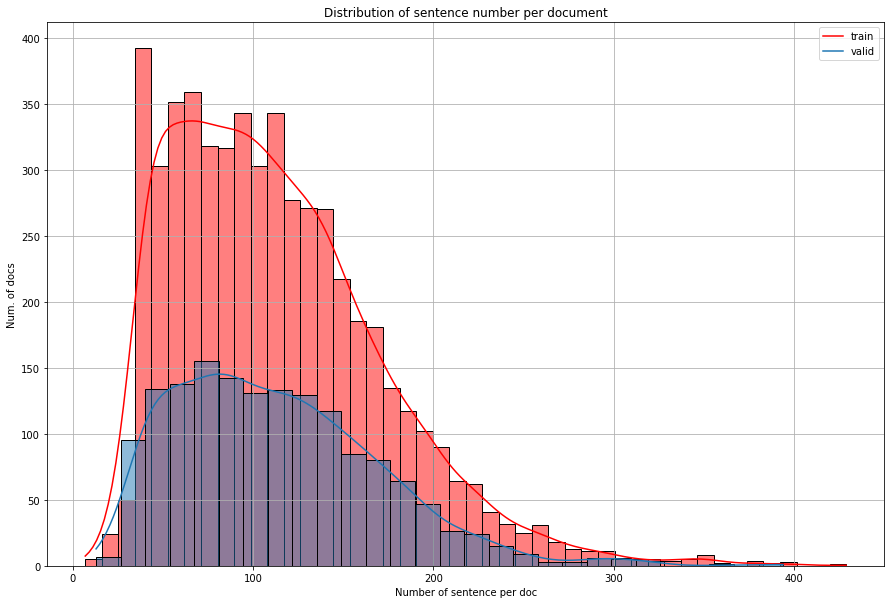

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Distribution of sentence number per document")
h = sns.histplot([len(i) for i in train_sents_per_doc], kde=True, color="red")
h = sns.histplot([len(i) for i in valid_sents_per_doc], kde=True)
h.set_ylabel("Num. of docs")
h.set_xlabel("Number of sentence per doc")
h.legend(labels=["train", "valid"])
plt.grid()
plt.show()

In [ ]:
# эти функции помогут нам сегментировать документы на предложения, токены и bpe-токены
from transformers import BertTokenizer  # BPE токенизация

In [ ]:
tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base', do_lower_case=False, max_len=10000)
print("====== TOKINIZER ======")
print(tokenizer)

Downloading:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/590 [00:00<?, ?B/s]

====== TOKINIZER ======
PreTrainedTokenizer(name_or_path='sberbank-ai/ruBert-base', vocab_size=120138, model_max_len=10000, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


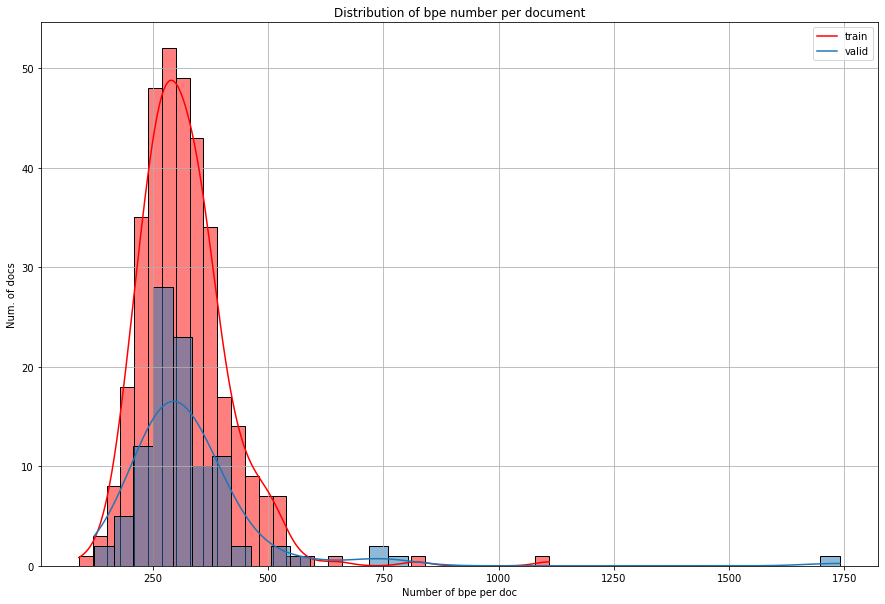

In [ ]:
train_bpe_per_docs = [tokenizer.tokenize(text) for text, _ in train_data]
valid_bpe_per_docs = [tokenizer.tokenize(text) for text, _ in valid_data]


plt.figure(figsize=(15,10))
plt.title("Distribution of bpe number per document")
h = sns.histplot([len(i) for i in train_bpe_per_docs], kde=True, color="red")
h = sns.histplot([len(i) for i in valid_bpe_per_docs], kde=True)
h.legend(labels=["train", "valid"])
h.set_ylabel("Num. of docs")
h.set_xlabel("Number of bpe per doc")
plt.grid()
plt.show()

In [ ]:
train_bpe_per_sentence = [tokenizer.tokenize(sentence) for sentence in train_sents_per_doc]
valid_bpe_per_sentence = [tokenizer.tokenize(sentence) for sentence in valid_sents_per_doc]
test_bpe_per_sentence = [tokenizer.tokenize(sentence) for sentence in test_sents_per_doc]

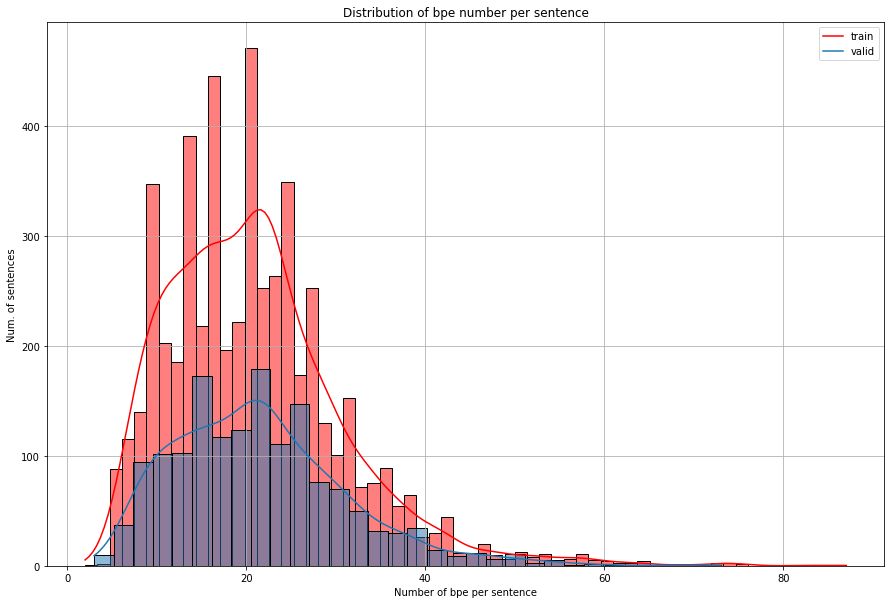

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Distribution of bpe number per sentence")
h = sns.histplot([len(i) for i in train_bpe_per_sentence], kde=True, color="red")
h = sns.histplot([len(i) for i in valid_bpe_per_sentence], kde=True)
h.legend(labels=["train", "valid"])
h.set_ylabel("Num. of sentences")
h.set_xlabel("Number of bpe per sentence")
plt.grid()
plt.show()

#### Задача 1

Как много уникальных текстов сущностей есть в каждом наборе данных (относительно всех текстов сущностей в данном наборе): 

`set(train_entities)/list(train_entities)`. 

Функция принимает на вход список семплов из набора, возвращает чет уникальных текстов сущностей (без привязки к типу) и список всех текстов сущностей. Округлить до 3 символа.

In [ ]:
# Заготовка

def unique_entity_texts(dataset: List[Tuple[str, List[Tuple[int, int, str]]]]):
    ent_texts = [] 
    """
    Ваш код здесь
    """
    for text, ents in dataset:
      for ent_start, ent_end, ent_type in ents:
        ent_texts.append(text[ent_start : ent_end])
    unique_ent_texts = set(ent_texts)
    print(f"Entities in dataset: {len(ent_texts)}")
    print(f"Unique entity texts in dataset: {len(unique_ent_texts)}")
    print(f"Relation unique ent texts to all ent texts: {round(len(unique_ent_texts) / len(ent_texts), 3)}")
    return unique_ent_texts, ent_texts

In [ ]:
# Заготовка
def iou(
    first_set: Set[str], 
    second_set: Set[str]
    ):
    """
    Ваш код здесь
    """
    return len(first_set & second_set) / len(first_set | second_set), first_set & second_set

def general_iou(
    unique_ent_texts_train: Set[str], 
    unique_ent_texts_valid: Set[str], 
    unique_ent_texts_test: Set[str]
    ):
    """
    Ваш код здесь
    """
    val_train_sc, val_train_inter = iou(unique_ent_texts_train, unique_ent_texts_valid)
    test_train_sc, test_train_inter = iou(unique_ent_texts_train, unique_ent_texts_test)

    return (
        round(val_train_sc, 4), 
        # val_train_inter,
        round(test_train_sc, 4), 
        # test_train_inter
    )

In [ ]:
unique_ent_texts_train, _ = unique_entity_texts(train_data)
unique_ent_texts_valid, _ = unique_entity_texts(valid_data)
unique_ent_texts_test, _ = unique_entity_texts(test_data)

valid_train_iou, test_train_iou = general_iou(unique_ent_texts_train, unique_ent_texts_valid, unique_ent_texts_test)

Entities in dataset: 14272
Unique entity texts in dataset: 5849
Relation unique ent texts to all ent texts: 0.41
Entities in dataset: 4449
Unique entity texts in dataset: 2607
Relation unique ent texts to all ent texts: 0.586
Entities in dataset: 3109
Unique entity texts in dataset: 1968
Relation unique ent texts to all ent texts: 0.633


#### Задача 3

In [ ]:
from utils import shift_entities

def add_markup_to_each_sentence(data: list):
    flatten_data_with_shift_ents = []
    for document_text, markup in data:
        sentences_infos = sentence_segmentation([document_text], True)
        ent_per_sents = shift_entities(sentences_infos, markup)
        for sent_info, sent_ent, in zip(sentences_infos, ent_per_sents):
            flatten_data_with_shift_ents.append((sent_info, sent_ent))
    return flatten_data_with_shift_ents

train_sentence_samples = add_markup_to_each_sentence(train_data)
print()
valid_sentence_samples = add_markup_to_each_sentence(valid_data)
print()
test_sentence_samples = add_markup_to_each_sentence(test_data)




Entity (1556, 1571, 'ORGANIZATION') was skipped due to incorrect segmentation in sentence #(14, 'Также занимал должность вице-президента и научного сотрудника в Yahoo!')


In [ ]:
for (_, _, text), markup in train_sentence_samples[:4]:
  show_span_line_markup(text, markup)
  print()

In [ ]:
from utils import filter_entities

needed_ents = {'PERSON', 'ORGANIZATION'}
valid_sentence_samples = filter_entities(valid_sentence_samples, needed_ents)
train_sentence_samples = filter_entities(train_sentence_samples, needed_ents)
test_sentence_samples = filter_entities(test_sentence_samples, needed_ents)

In [ ]:
print(f"Train samples: {len(train_sentence_samples)}")
print(f"Valid samples: {len(valid_sentence_samples)}")
print(f"Test samples: {len(test_sentence_samples)}")

Train samples: 5302
Valid samples: 1556
Test samples: 1076


#### DataLoader

In [ ]:
# Заготовка

class CustomDataset(Dataset):

    def __init__(
            self, 
            samples: list, 
            out_label: str = "O", 
            max_seq_len: int = 512,
            pad_index: int = -100

    ):

        self.out_label = out_label
        self.max_seq_len = max_seq_len
        self.pad_index = pad_index


        # в первом эксперименте мы будем использовать IO схему теггирования, 
        # если немного поразмышлять, то поймем - IO схема, значит что никаких префиксов к типам сущностей мы можем и не добавлять
        labels = [out_label, 'PERSON', 'ORGANIZATION']
        self.label_to_id = {label: index for index, label in enumerate(labels)}

        self.tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base', max_len=10000)
        # так как интерфейс tokenizers в HF одинаковый, то вы сможете легко попробовать и другие модели
        # self.tokenizer = RobertaTokenizerFast.from_pretrained('blinoff/roberta-base-russian-v0', max_len=10000)

        self.tokens_per_sample, self.data = [], []

        self.wpt = WordPunctTokenizer()

        for sentence_info, markup in tqdm(samples):
            sample_tensors, tokens_positions = self.prepare_sentence(
                sentence_info, markup, self.wpt.span_tokenize
            )
            self.data.append(sample_tensors)
            self.tokens_per_sample.append(tokens_positions)

    def prepare_sentence(
          self, sentence_info: tuple, ents: list, tokenize_fn: Callable
    ) -> Tuple[Dict[str, torch.tensor], List[Tuple[int, int, str]]]:
        """
        Задача:
        1. Разбить текст входного предложения на токены с координатами, то есть
            реализовать метод tokenize_sentence

        2. Подготовить список лейблов (на каждый токен):
            - сначала проинициализируйте все падами
            - потом заполните пады реальными лейблами: для этого используйте
              координаты токенов и координаты сущностей в символах
            то есть реализуйте метод convert_span2labels
        3. Инициализируем списки labels_ids, token_start_mask со значением -100
        4. Инициализируем tokens_ids с одним элементом - индекс токена CLS (используйте 
            метод convert_tokens_to_ids у BPE токенизатора)

        5. Идем циклом сразу по двум спискам токены и лейблы
            - токен разбиваем на bpe
            - переводим bpe в индексы
            - добавляем в список tokens_ids
            - конвертируем лейбл в индекс и дублируем столько раз,
              сколько получилось бпе в токене
            - добавляем в список labels_ids
            - создаем на каждый токен token_start_mask_id,
              где первый элемент индекс лейбл, а остальные -100 (будем потом 
                  использовать для конвертации и расчета метрик)
            - добавляем список token_start_mask_id к token_start_mask 

        6. Паддим до максимальной длины или обрезаем списки
        7. Конвертируем в тензора и собираем тензора в словарь

        """
        s_start, s_end, sentence = sentence_info

        tokens_per_sample = self.tokenize_sentence(sentence, tokenize_fn)

        labels = self.convert_span2labels(self.out_label, ents, tokens_per_sample)

        """
        Ваш код здесь
        """
        labels_ids = [self.pad_index]
        token_start_mask = [self.pad_index]
        token_ids = self.tokenizer.convert_tokens_to_ids(['CLS'])

        for (_, _, token_text), label in zip(tokens_per_sample, labels):
          bpes = self.tokenizer.tokenize(token_text)
          if not bpes:
            bpes = ['[UNK]']
            token_ids.extend(self.tokenizer.convert_tokens_to_ids(bpes))
          else:
            token_ids.extend(self.tokenizer.convert_tokens_to_ids(bpes))
          
          token_label_ids = [self.label_to_id[label]]
          token_start_mask_id = [self.label_to_id[label]]

          if len(bpes) > 1:
            token_label_ids.extend([self.label_to_id[label]] * (len(bpes) - 1))
            token_start_mask_id.extend([self.pad_index] * (len(bpes) - 1))
        
          labels_ids.extend(token_label_ids)
          token_start_mask.extend(token_start_mask_id)

        if len(token_ids) >= self.max_seq_len:
          return {
                'input_ids' : torch.as_tensor(token_ids[:self.max_seq_len], dtype=torch.int64),
                'attention_mask' : torch.as_tensor([1]*self.max_seq_len, dtype=torch.float32),
                'labels' : torch.as_tensor(labels_ids[:self.max_seq_len], dtype=torch.int64),
                'token_start_mask' : torch.as_tensor(token_start_mask[:self.max_seq_len], dtype=torch.int64)
                }, tokens_per_sample

        pad = self.max_seq_len - len(token_ids)
        return {
                'input_ids' : torch.as_tensor(token_ids + [0]*pad, dtype=torch.int64),
                'attention_mask' : torch.as_tensor([1]*len(token_ids) + [0]*pad, dtype=torch.float32),
                'labels' : torch.as_tensor(labels_ids + [-100]*pad, dtype=torch.int64),
                'token_start_mask' : torch.as_tensor(token_start_mask + [-100]*pad, dtype=torch.int64)
                }, tokens_per_sample


    @staticmethod
    def tokenize_sentence(sentence: str, tokenize_fn: Callable):
        """
        На вход ожидается предложение и функция для токенизация,
        а на выходе список из туплов с информацией о расположении токенов
        
        Я иду домой -> (0, 1, я) (2, 5, иду) (6, 11, домой)
        
        """
        tokens_per_sample = []
        """
        Ваш код здесь
        """
        start_token = 0
        for start, end in tokenize_fn(sentence):
          token = sentence[start:end]
          tokens_per_sample.append((start, end, token))

        return tokens_per_sample

    @staticmethod
    def convert_span2labels(
            out_label: str, ents: list, tokens_per_sample: list
    ):
        """
        На вход ожидается значение out_label токена, список сущностей и
        список токенов с мета информацией. Пересекаем здесь сущности
        по координатам с токенами и возвращемс список лейблов.
        Количество лейблов должно быть равно количеству токенов.
        """
        labels = [out_label] * len(tokens_per_sample)
        """
        Ваш код здесь
        """
        for start_ents, end_ents, ent in ents:
            ind = 0
            for start_t, end_t, token in tokens_per_sample:
                if start_ents <= start_t and end_t <= end_ents:
                    labels[ind] = ent        
                ind += 1
        return labels

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [ ]:
train = [i for i in train_sentence_samples if i[1]]
valid = [i for i in valid_sentence_samples if i[1]] 
test = [i for i in test_sentence_samples if i[1]] 
print(f"Train samples: {len(train)}")
print(f"Valid samples: {len(valid)}")
print(f"Test samples: {len(test)}")

Train samples: 2764
Valid samples: 925
Test samples: 609


In [ ]:
MAX_SEQ_LEN = 128
train_ds = CustomDataset(train, max_seq_len=MAX_SEQ_LEN)
valid_ds = CustomDataset(valid, max_seq_len=MAX_SEQ_LEN)
test_ds = CustomDataset(test, max_seq_len=MAX_SEQ_LEN)

  0%|          | 0/2764 [00:00<?, ?it/s]

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/609 [00:00<?, ?it/s]

In [ ]:
NUM_WORKERS = 2
train_dl = DataLoader(train_ds, batch_size=16, num_workers=NUM_WORKERS)
valid_dl = DataLoader(valid_ds, batch_size=16, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_ds, batch_size=16, num_workers=NUM_WORKERS, shuffle=False)

#### Модель

In [ ]:
import pytorch_lightning as pl


class NERModel(pl.LightningModule):

    def __init__(self, num_labels: int = 3):

        super().__init__()

        # self.model = RobertaForTokenClassification.from_pretrained('blinoff/roberta-base-russian-v0', num_labels=3)
        # Готовая модель из transofomers
        self.model = BertForTokenClassification.from_pretrained('sberbank-ai/ruBert-base', num_labels=num_labels)

        # Сюда будем складвать данные по бачам из валидации, чтобы в конце эпохи рассчитать метрики
        self.data_to_eval = []

        self.index2label = {0: "O", 1: 'PERSON', 2:'ORGANIZATION'}

    def training_step(self, batch, batch_idx):

        out = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
            )
        
        self.log('train_loss', out.loss)

        return out.loss

    def validation_step(self, batch, batch_idx):

        out = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
            )
        
        self.log('val_loss', out.loss)
        logits = out.logits.argmax(dim=-1)

        self.data_to_eval.append(
            (logits.cpu().numpy(), batch["token_start_mask"].cpu().numpy())
        )

    def on_validation_end(self) -> None:        
        self.count_metrics()
        self.data_to_eval = []

    def count_metrics(self):
      
      flat_preds, flat_target = [], []
      for preditions, targets in self.data_to_eval:
        for sample_pred, sample_target in zip(preditions, targets):
          for index, s_t in enumerate(sample_target):
            if s_t != -100:
              flat_target.append(s_t)
              flat_preds.append(sample_pred[index])
      
      report = classification_report(
          flat_target, flat_preds, target_names = ['O','PERSON','ORGANIZATION'], output_dict = True
      )
      for key_report in report:
        if key_report == "accuracy":
          continue
        self.trainer.logger.experiment.log(
          {f"F1-score: {key_report.upper()}": report[key_report]["f1-score"]}
        )
        print(f"F1-score - {key_report.upper()} : {report[key_report]['f1-score']}")
      print()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-6)
        return optimizer

    def predict(self, predict_dl: DataLoader):
      self.eval()
      preds = []
      with torch.no_grad():
        for batch in predict_dl:
          batch = {k: v.to(self.device) for k, v in batch.items()}
          out = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
            )
          predictions = out.logits.argmax(dim=-1).cpu().numpy()
          preds.extend(
              self.format_predictions(predictions, batch["token_start_mask"])
              )
      return preds
          
    def format_predictions(self, predictions: torch.tensor, tokens_mask: torch.tensor):
      """
      Метод предназначен для создания лейблов из предсказанных логитов модели.
      У нас есть тензор-маска - tokens_mask. Используем значение -100, чтобы только 
      с этих токенов снимать лейблы. Остальные логиты нас не интересуют. Поясню:
      
      С чем работает модель:
      BPE         [Абра #кад #абра искомое слово]
      predictions [2    2   2    0      0   ]
      tokens_mask [-100 0   0    -100   -100]

      С чем хотим работать мы:
      Токены       [Абракадабра    искомое слово]
      labels      [2             0      0   ]

      """
      batch_preds = []
      for pred, mask in zip(predictions, tokens_mask):

        batch_preds.append(
            [self.index2label[pred[i_m]] for i_m, mask_value in enumerate(mask) if mask_value != -100]
        )
      return batch_preds
          
              

In [ ]:
m = NERModel()

Downloading:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized fr

In [ ]:
import os
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

logs_dir = "logs"
project_name = "sber-td-course"
exp_name = "ruBert-base-v2"


os.environ['WANDB_API_KEY'] = open('/content/drive/MyDrive/ssh/wandbkey.txt').read().strip()
logger = WandbLogger(
    save_dir=logs_dir,
    project=project_name,
    name=exp_name,
)

# для простоты будем мониторить лосс и по нему сохранять чекпоинты
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./check_points",
    filename="runne_ner-{epoch:02d}-{val_loss:.4f}",
    save_top_k=2,
    mode="min",
)

trainer = pl.Trainer(
    num_sanity_val_steps=0, 
    gpus=[0], 
    max_epochs=5, 
    logger=logger,
    callbacks=[checkpoint_callback]
)

trainer.fit(m, train_dl, valid_dl)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | BertForTokenClassification | 177 M 
---------------------------------------

Training: 0it [00:00, ?it/s]

wandb: Currently logged in as: nosenkoartyom1989. Use `wandb login --relogin` to force relogin
wandb: WARNING Path logs/wandb/ wasn't writable, using system temp directory.


Validation: 0it [00:00, ?it/s]

F1-score - O : 0.980057320277048
F1-score - PERSON : 0.9539136795903438
F1-score - ORGANIZATION : 0.8381517173214726
F1-score - MACRO AVG : 0.9240409057296214
F1-score - WEIGHTED AVG : 0.9640767310150689



Validation: 0it [00:00, ?it/s]

F1-score - O : 0.9841858240411349
F1-score - PERSON : 0.96602658788774
F1-score - ORGANIZATION : 0.8706455542021925
F1-score - MACRO AVG : 0.9402859887103557
F1-score - WEIGHTED AVG : 0.9714957104662566



Validation: 0it [00:00, ?it/s]

F1-score - O : 0.9860334360139966
F1-score - PERSON : 0.9713866471019809
F1-score - ORGANIZATION : 0.8861313868613138
F1-score - MACRO AVG : 0.9478504899924305
F1-score - WEIGHTED AVG : 0.9749140242210492



Validation: 0it [00:00, ?it/s]

F1-score - O : 0.9865940511101802
F1-score - PERSON : 0.9705882352941176
F1-score - ORGANIZATION : 0.8915779283639884
F1-score - MACRO AVG : 0.9495867382560954
F1-score - WEIGHTED AVG : 0.975946132697591



Validation: 0it [00:00, ?it/s]

F1-score - O : 0.9875320646662292
F1-score - PERSON : 0.9715536105032823
F1-score - ORGANIZATION : 0.8950909543982059
F1-score - MACRO AVG : 0.9513922098559058
F1-score - WEIGHTED AVG : 0.9771585501076984



INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
!ls check_points

'runne_ner-epoch=02-val_loss=0.1019.ckpt'
'runne_ner-epoch=04-val_loss=0.1020.ckpt'


#### Загрузка модели

In [ ]:
best_model_path = checkpoint_callback.best_model_path
best_model_path

'/content/check_points/runne_ner-epoch=02-val_loss=0.1019.ckpt'

In [ ]:
model = NERModel.load_from_checkpoint(best_model_path)

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized fr

In [ ]:
def transform_logits_to_char_spans(dataset: CustomDataset, logits: torch.tensor):


  transfomed_predictions = []

  # Проверим что количество предсказаний и количество исходных примеров совпадают
  assert len(dataset.tokens_per_sample) == len(logits), "len(dataset.tokens_per_sample) != len(logits)"


  # Итерируемся по предложению (разбито на токены) и логитам
  for sample, markup in zip(dataset.tokens_per_sample, logits):

    # Для каждого предложения будем собирать исходный текст из окенов и позиций
    text_sample = [" "] * sample[-1][1]
    # Здесь будут храниться символьные координаты сущностей
    char_coords = []

    prev_ent = None
    
    # Итерируемся по токенам и лейблам для того, чтобы перейти от потокенной классификации к символьным спанам
    for (s, e, token), label in zip(sample, markup):
        text_sample[s:e] = list(token)

        # Если предсказанный лейбл == "O", обрабатываем две ситуации: 
        #  - Завершаем создание некоторого спана, то есть сущности
        #  - Пропускаем токен
        if label == "O":
          if prev_ent:
            char_coords.append(prev_ent)
          prev_ent = None
          continue

        # Если предсказанный лейбл != "O", обрабатываем две ситуации: 
        #  - Обновляем существующий спан, продлеваем его на один токен вправо
        #  - Начинаем создавать новый спан
        if prev_ent:
          if label != prev_ent[-1]:
            char_coords.append(prev_ent)
            prev_ent = s, e, label
            continue
          if label == prev_ent[-1]:
            prev_ent = prev_ent[0], e, prev_ent[-1]
            continue

        if prev_ent is None:
          prev_ent = s, e, label
          continue

    # Не забываем обработать последний токен
    if prev_ent:
      if label != prev_ent[-1]:
        char_coords.append(prev_ent)
        char_coords.append((s, e, label))
      if label == prev_ent[-1]:
        char_coords.append((prev_ent[0], e, prev_ent[-1]))

    # Склеиваем тексты из токенов, которые мы собирали
    transfomed_predictions.append((''.join(text_sample), char_coords)) 
   
  return transfomed_predictions

In [ ]:
def inference_model(
    model: torch.nn.Module, 
    device: str, 
    dataset: CustomDataset, 
    dataloader: DataLoader
  ) -> List[Tuple[str, list]]:
  """
  Переносим модель на девайс
  Выполняем предикт с помощью модели
  Преобразуем логиты в символьные спаны
  """
  model = model.to(device)
  logits = model.predict(dataloader)
  return transform_logits_to_char_spans(dataset, logits)

In [ ]:
from collections import Counter


def get_lists_diff(a: list, b: list) -> Tuple[list, list]:
    a_counter = Counter(a)
    b_counter = Counter(b)
    only_a = (a_counter - b_counter).elements()
    only_b = (b_counter - a_counter).elements()
    return list(only_a), list(only_b)


def get_spans_diff(
        gold_spans: List[tuple], predicted_spans: List[tuple]
) -> List[tuple]:
    only_gold, only_predicted = get_lists_diff(gold_spans, predicted_spans)
    spans = [(start, end, "G_" + type) for start, end, type in only_gold]
    spans.extend([(start, end, "P_" + type) for start, end, type in only_predicted])
    return spans


def visualize_difference(target_samples, 
             predictoons, 
             n_samples = 10, 
             ):
  for target_markup, predition in list(zip(test, result))[:n_samples]:
    sentence_with_coord, gols_entities = target_markup
    _, predited_entities = predition
    diff = get_spans_diff(gols_entities, predited_entities) 
    show_span_line_markup(sentence_with_coord[-1], diff)
    print()

#### Конвертация в jit

In [ ]:
import random 

bert = model.model
bert.eval()

max_seq_len = 256

tokens_tensor = torch.tensor([[random.randint(0, 33000) for i in range(max_seq_len)]])
att_mask_tensors = torch.tensor([[1] * max_seq_len])

module = torch.jit.trace(bert.to('cpu'), [tokens_tensor, att_mask_tensors], strict=False)

torch.jit.save(module, "./ner_runne.jit")

In [ ]:
model = torch.jit.load("./ner_runne.jit")
index2label = {0: "O", 1: 'PERSON', 2:'ORGANIZATION'}

def format_predictions(
    predictions: torch.tensor, 
    tokens_mask: torch.tensor, 
    dictionary: Dict[int, str]
  ) -> List[List[str]]:
    batch_preds = []
    for pred, mask in zip(predictions, tokens_mask):
        batch_preds.append(
            [index2label[pred[i_m]]
             for i_m, mask_value in enumerate(mask)
             if mask_value != -100]
        )
    return batch_preds

In [ ]:
def predict(model, predict_dl, device, dictionary):
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in predict_dl:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            predictions = out["logits"].argmax(dim=-1).cpu().numpy()
            preds.extend(
                format_predictions(predictions, batch["token_start_mask"], dictionary)
            )
    return preds

In [ ]:
def inference_jit_model(model, device, dataset, dataloader, dictionary) -> List[Tuple[str, list]]:
    model = model.to(device)
    logits = predict(model, dataloader, device, dictionary)
    return transform_logits_to_char_spans(dataset, logits)

### Реальный пример

In [ ]:
news_sample = """Ваше королевское. Карл III взошел на престол в трудное время. Станет ли его правление закатом британской монархии? Смерть королевы Великобритании Елизаветы II стала серьезным потрясением для нации: монарх правила более 70 лет и казалась многим чем-то неизменным, константой в постоянно меняющейся окружающей действительности. После смерти королевы на престол взошел ее старший сын принц Чарльз, принявший имя Карл III. Нового короля ждет весьма непростое правление. В Соединенном Королевстве все отчетливее прослеживаются тенденции к разъединению: Шотландия готовится к уже второму референдуму о независимости, а на выборах в Северной Ирландии победила националистическая партия «Шинн Фейн», выступающая за объединение с Республикой Ирландия. Неспокойно и в других 14 государствах, где британский монарх по-прежнему считается главой государства: там все громче звучат призывы порвать с монархией и объявить себя республиками. На правление Елизаветы II пришелся закат Британской империи. Станет ли правление Карла III закатом британского королевства и монархии вообще — разбиралась «Лента.ру»."""
print(news_sample)

Ваше королевское. Карл III взошел на престол в трудное время. Станет ли его правление закатом британской монархии? Смерть королевы Великобритании Елизаветы II стала серьезным потрясением для нации: монарх правила более 70 лет и казалась многим чем-то неизменным, константой в постоянно меняющейся окружающей действительности. После смерти королевы на престол взошел ее старший сын принц Чарльз, принявший имя Карл III. Нового короля ждет весьма непростое правление. В Соединенном Королевстве все отчетливее прослеживаются тенденции к разъединению: Шотландия готовится к уже второму референдуму о независимости, а на выборах в Северной Ирландии победила националистическая партия «Шинн Фейн», выступающая за объединение с Республикой Ирландия. Неспокойно и в других 14 государствах, где британский монарх по-прежнему считается главой государства: там все громче звучат призывы порвать с монархией и объявить себя республиками. На правление Елизаветы II пришелся закат Британской империи. Станет ли пра

In [ ]:
%%time
segmented_news_sample = sentence_segmentation([news_sample], return_coords=True) #  Вернем координаты предложений, чтоб если что собрать целый текст (то есть сдвинуть сущности)
example_ds = CustomDataset(samples=[(s, []) for s in segmented_news_sample]) #  Подготовим загрузчик данных, эмулируем сущности пустым списком
example_dl = DataLoader(example_ds, batch_size=16) #  Собираем все в батчи
example_result = inference_jit_model(model, "cuda:0", example_ds, example_dl, index2label) #  Инференс модели и конвертация в символьные спаны

for sample_predictions in example_result:
  show_span_line_markup(*sample_predictions)
  print()

  0%|          | 0/10 [00:00<?, ?it/s]


CPU times: user 1.22 s, sys: 181 ms, total: 1.4 s
Wall time: 2.39 s
